**Exploratory Data Analysis (EDA) of the UrbanSound8K Dataset**

In this notebook, we will perform a preliminary analysis of the UrbanSound8K dataset. The goal is to better understand the data structure, class distribution, and audio file characteristics before proceeding with training a machine learning model.

**Objectives:**
1. Analyze the metadata (`UrbanSound8K.csv`).
2. Examine the distribution of classes and folds.
3. Analyze the duration of audio clips.
4. Load and visualize audio data.

In [9]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import librosa

# Plot settings
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (16, 6)

**1. Analyze the metadata**

The file `UrbanSound8K.csv` contains all the information about the audio files, including their labels (classes) and the fold to which they belong.

In [10]:
BASE_DATASET_PATH = "../UrbanSound8K/UrbanSound8K/"
METADATA_PATH = os.path.join(BASE_DATASET_PATH, "metadata", "UrbanSound8K.csv")
AUDIO_BASE_PATH = os.path.join(BASE_DATASET_PATH, "audio")

try:
    df = pd.read_csv(METADATA_PATH)
    print("Metadata loaded successfully!")
except FileNotFoundError:
    print(f"ERROR: File not found at '{METADATA_PATH}'. Please make sure the path is correct.")
    df = None

if df is not None:
    print(f"The dataset contains {len(df)} audio files.")
    display(df.head())

Metadata loaded successfully!
The dataset contains 8732 audio files.


slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

Check data types and missing values

In [11]:
if df is not None:
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


**2. Examine the distribution of classes and folds**

A fundamental step is to check how many recordings we have for each class. An imbalanced dataset can negatively affect the model’s performance.

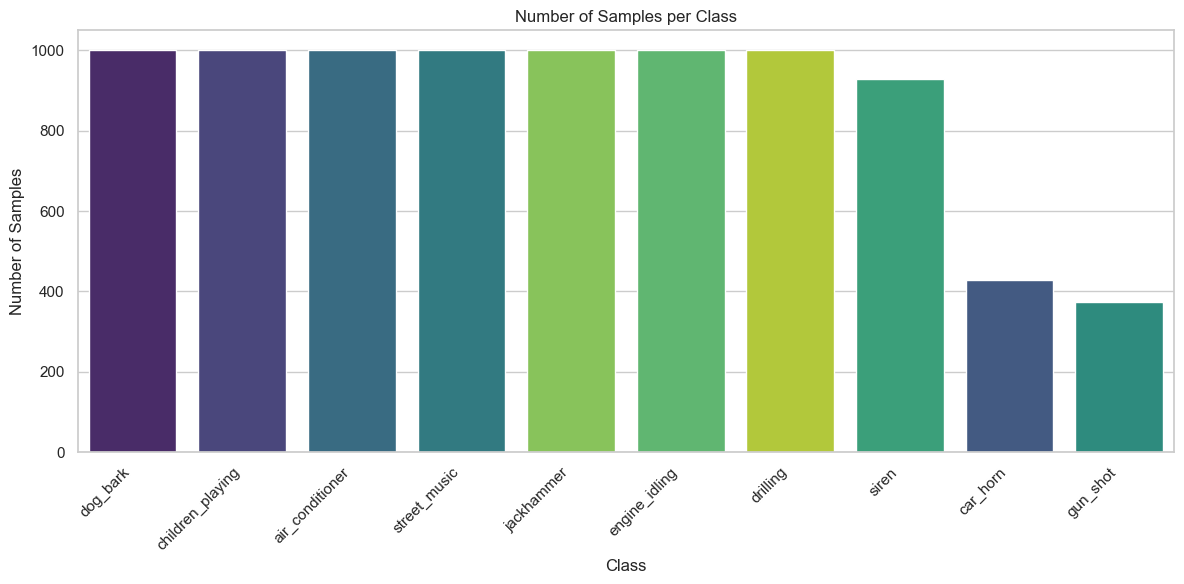

In [12]:
if df is not None:
    plt.figure(figsize=(12, 6))
    sns.countplot(
        x='class',
        hue='class',
        data=df,
        order=df['class'].value_counts().index,
        palette='viridis',
        legend=False
    )
    plt.title('Number of Samples per Class')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.tight_layout()
    plt.show()

The plot shows that the classes are not perfectly balanced. The classes `dog_bark`, `air_conditioner`, `street_music`, and `engine_idling` have more samples, while `car_horn` and `gun_shot` have fewer. This is an important factor to keep in mind during model evaluation.

The dataset is pre-divided into 10 folds for cross-validation. Let's check whether the data is evenly distributed across the folds.

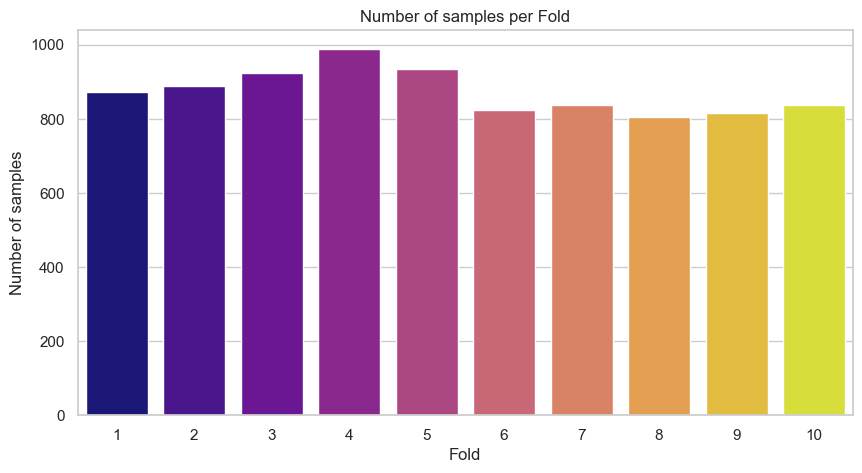

In [13]:
if df is not None:
    plt.figure(figsize=(10, 5))
    sns.countplot(
        x='fold',
        hue='fold',
        data=df,
        palette='plasma',
        legend=False
    )
    plt.title('Number of samples per Fold')
    plt.xlabel('Fold')
    plt.ylabel('Number of samples')
    plt.show()

The folds contain a similar number of samples, which is great for balanced cross-validation.

**3. Analyze the duration of audio clips**

Let's check the distribution of the actual durations of the audio files.

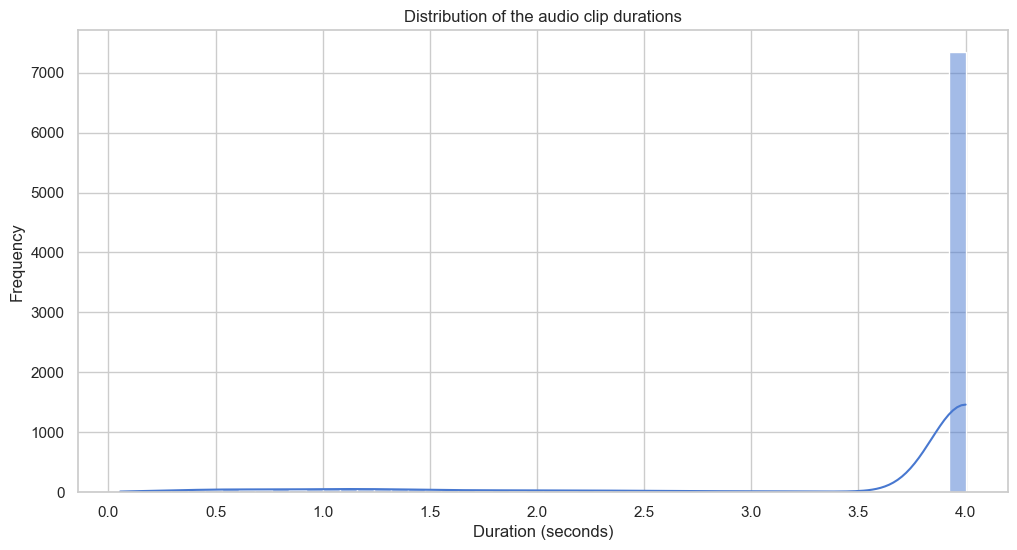

Duration statistics:
count    8732.000000
mean        3.607904
std         0.973570
min         0.054517
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: duration, dtype: float64

Percentage of files with duration > 4 seconds: 2.44%


In [14]:
if df is not None:
    df['duration'] = df['end'] - df['start']
    
    plt.figure(figsize=(12, 6))
    sns.histplot(df['duration'], bins=50, kde=True)
    plt.title('Distribution of the audio clip durations')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.show()

    print(f"Duration statistics:")
    print(df['duration'].describe())
    print(f"\nPercentage of files with duration > 4 seconds: {np.sum(df['duration'] > 4) / len(df) * 100:.2f}%")

The vast majority of audio files have a duration equal to or slightly less than 4 seconds. Therefore, the choice to standardize to 4 seconds makes a lot of sense: most files will be padded to reach 4 seconds.

**4. Load and visualize audio data**

Visualization of a Sample Audio File

File: 100852-0-0-7.wav
Class: air_conditioner
Path: ../UrbanSound8K/UrbanSound8K/audio\fold5\100852-0-0-7.wav


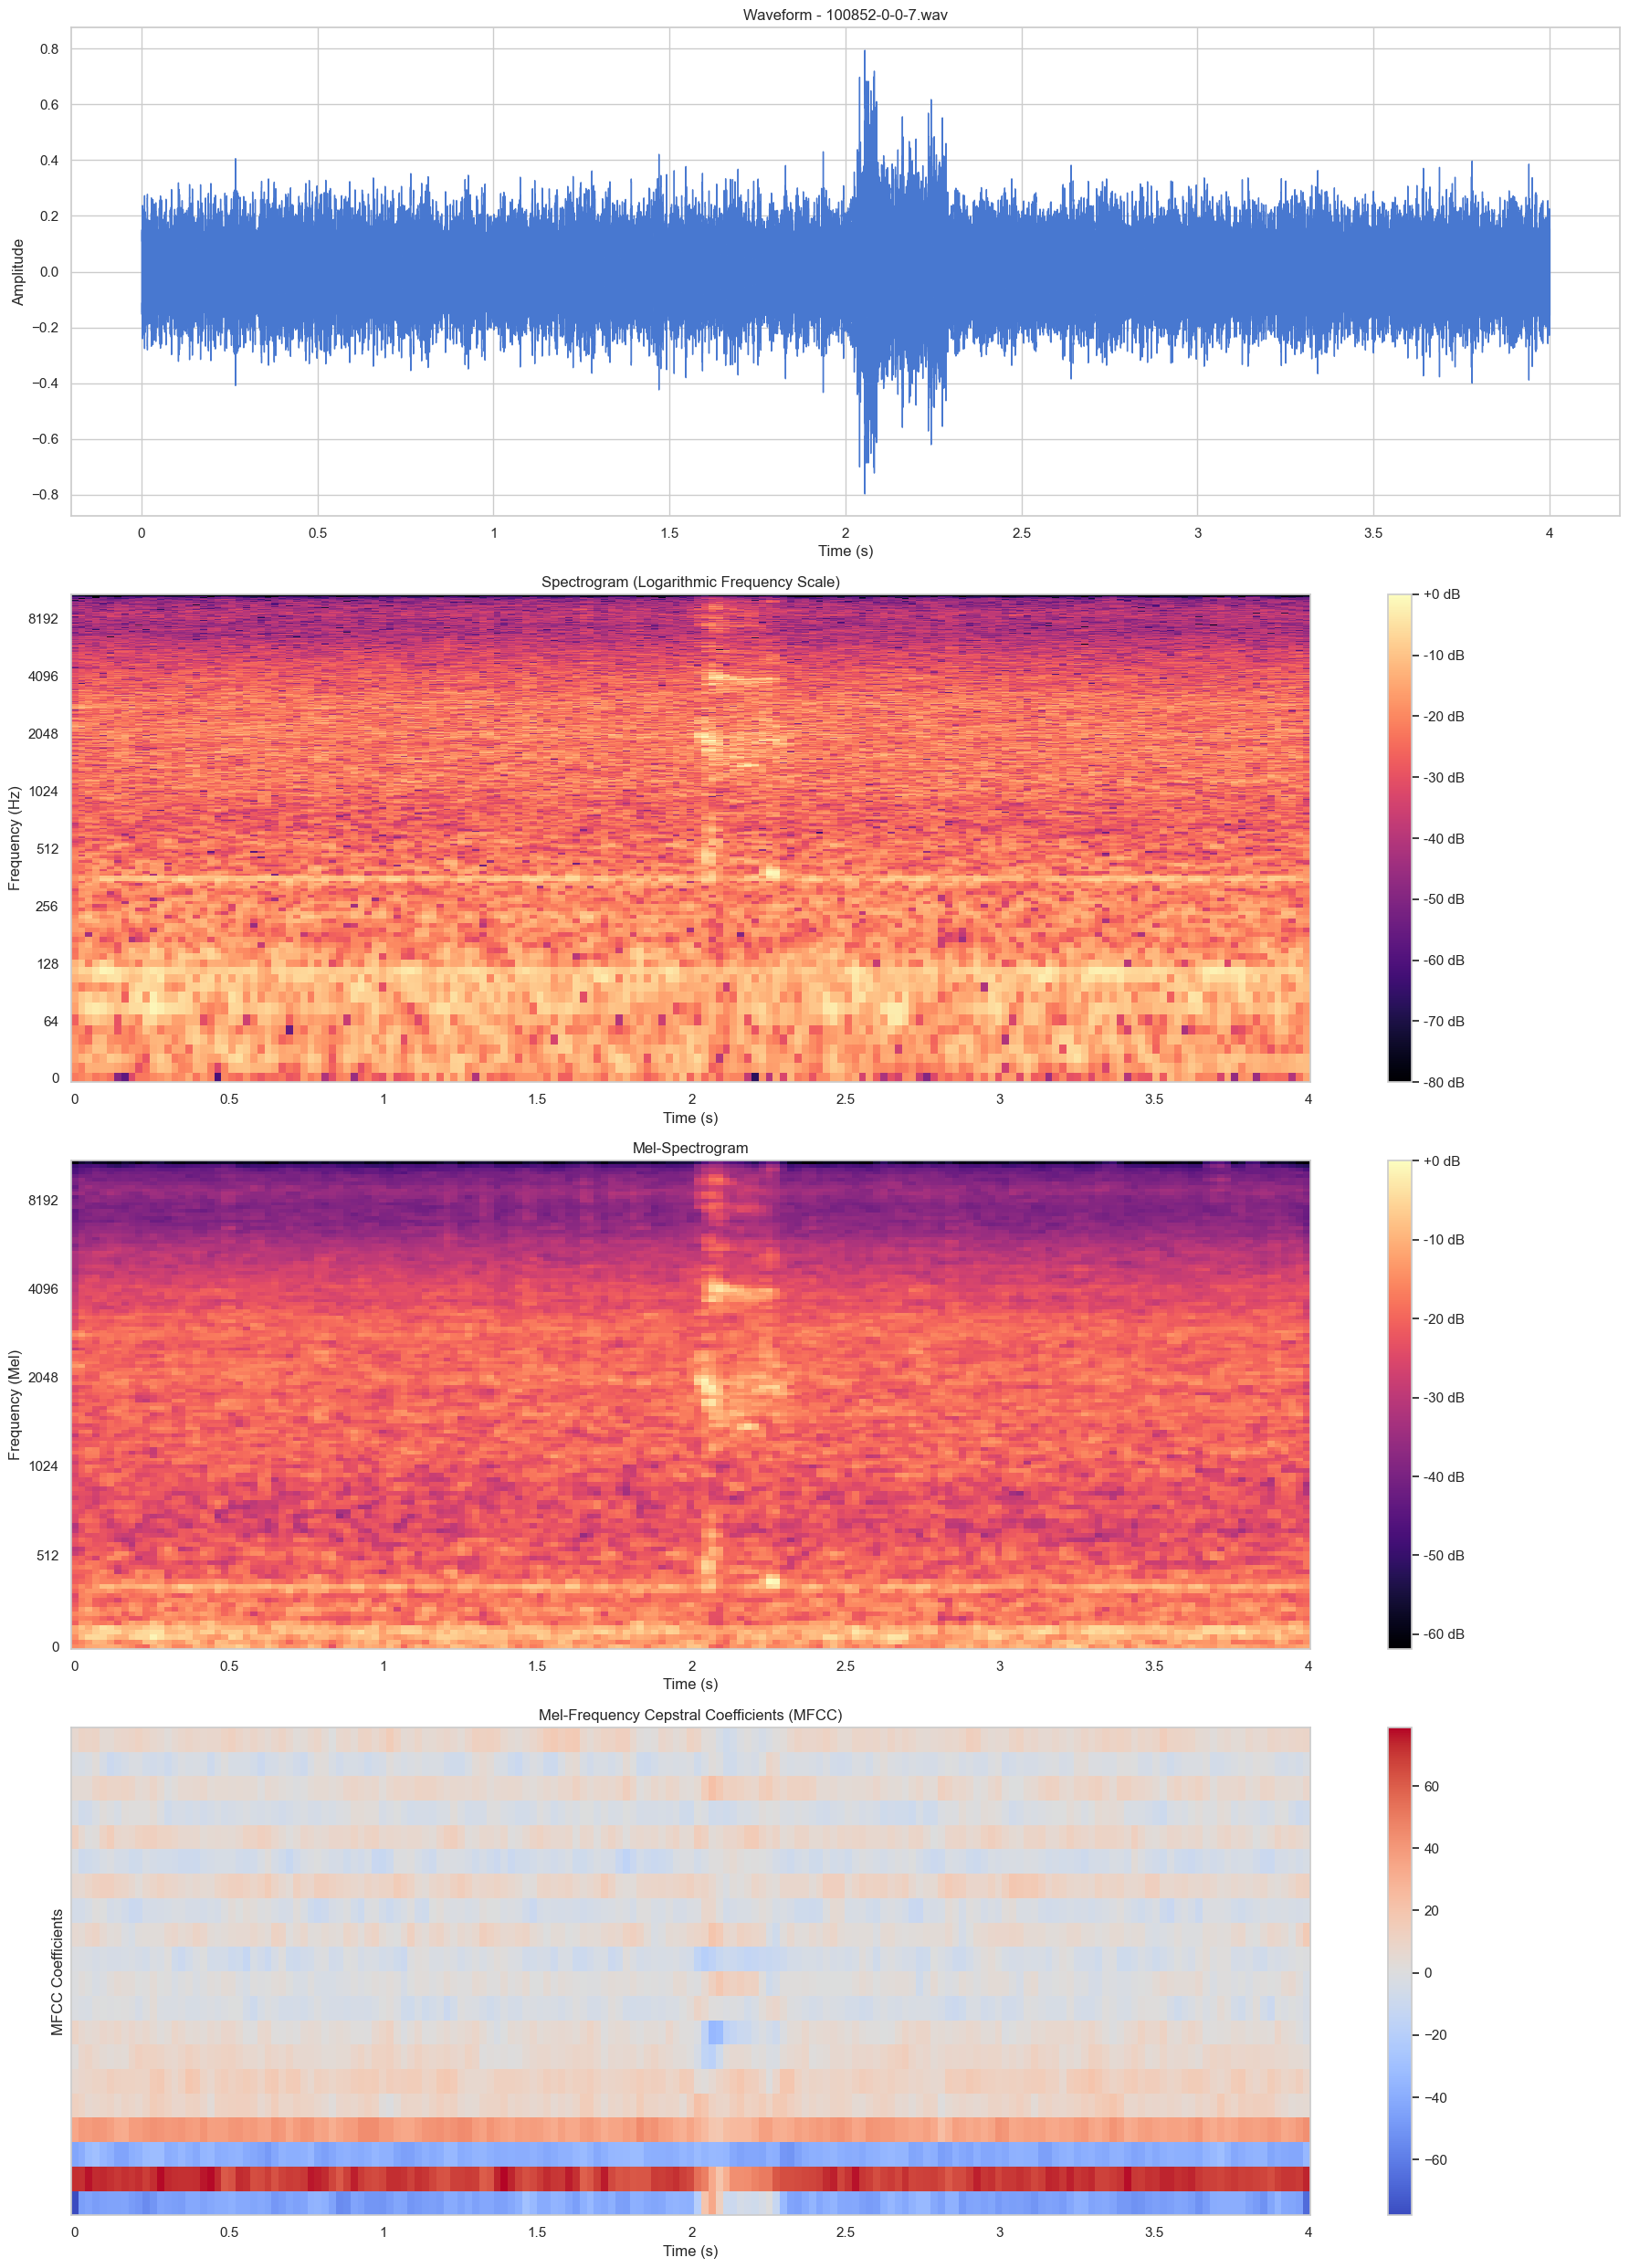

In [15]:
def plot_audio_representations(file_path, sample_rate=22050):
    """
    Load an audio file and plot its waveform, (log) spectrogram, 
    Mel-spectrogram, and MFCC.
    """
    try:
        # Load the audio file. Use 'sr=None' to keep the original sample rate, then resample.
        y, sr_orig = librosa.load(file_path, sr=None)
        # Resample if necessary for consistency
        if sr_orig != sample_rate:
            y = librosa.resample(y, orig_sr=sr_orig, target_sr=sample_rate)
        
        plt.figure(figsize=(18, 25))

        # 1. Plot of the Waveform
        plt.subplot(4, 1, 1)
        librosa.display.waveshow(y, sr=sample_rate)
        plt.title(f'Waveform - {os.path.basename(file_path)}')
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # Common calculation for spectrogram
        D = librosa.stft(y)  # Short-Time Fourier Transform
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max) # Convert amplitude to dB

        # 2. Plot of the Spectrogram (Logarithmic Frequency Scale)
        plt.subplot(4, 1, 2)
        librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram (Logarithmic Frequency Scale)')
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")


        # 3. Plot of the Mel-Spectrogram
        S_mel = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_mels=128)
        S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
        plt.subplot(4, 1, 3)
        librosa.display.specshow(S_mel_db, sr=sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-Spectrogram')
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Mel)")
        
        # 4. Plot of the Mel-Frequency Cepstral Coefficients (MFCC)
        mfccs = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=20)
        plt.subplot(4, 1, 4)
        librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
        plt.colorbar()
        plt.title('Mel-Frequency Cepstral Coefficients (MFCC)')
        plt.xlabel("Time (s)")
        plt.ylabel("MFCC Coefficients")
        
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Select a random file from the DataFrame
if df is not None:
    sample_row = df.iloc[50]
    file_name = sample_row['slice_file_name']
    fold_num = sample_row['fold']
    class_name = sample_row['class']
    
    file_path = os.path.join(AUDIO_BASE_PATH, f"fold{fold_num}", file_name)
    
    print(f"File: {file_name}")
    print(f"Class: {class_name}")
    print(f"Path: {file_path}")
    
    plot_audio_representations(file_path)


- **Waveform:** shows the amplitude of the audio signal over time. It's the most direct representation of sound, but difficult for a computer to interpret.

- **spectrogram (log):** breaks down sound into its constituent frequencies over time. The Y-axis represents frequency, the X-axis represents time, and the color indicates the intensity (in decibels) of each frequency at a given moment. This is much more informative than a waveform.
Audio signals have a huge difference between the weakest and strongest sounds. A linear scale would only emphasize the loudest peaks, while all the quieter details would be crushed at the bottom and appear black or dark blue, making the graph almost unreadable. This is why a logarithmic scale is used, as human perception of sound is also logarithmic.

- **Mel-spectrogram:** is a variant of the spectrogram where frequencies have been converted to the Mel scale. This scale more closely approximates human auditory perception (we are more sensitive to differences between low frequencies). This is the most commonly used feature in audio classification models.

- **Mel-Frequency Cepstral Coefficients:** are obtained by applying a logarithmic transformation to the Mel-spectrogram followed by a Discrete Cosine Transform (DCT), which captures the most relevant variations in the spectrum's shape.
The resulting coefficients do not directly represent frequencies or amplitudes, but rather encode the "acoustic fingerprint" of the sound, which is useful for distinguishing timbres, phonemes, or sound classes. 



To understand why a Convolutional Neural Network (CNN) can be effective [for audio classification], it's helpful to visualize how spectrograms differ between various classes.

--------------------------------------------------
Displaying a random sample for class: 'dog_bark'
Selected file: 44831-3-1-0.wav


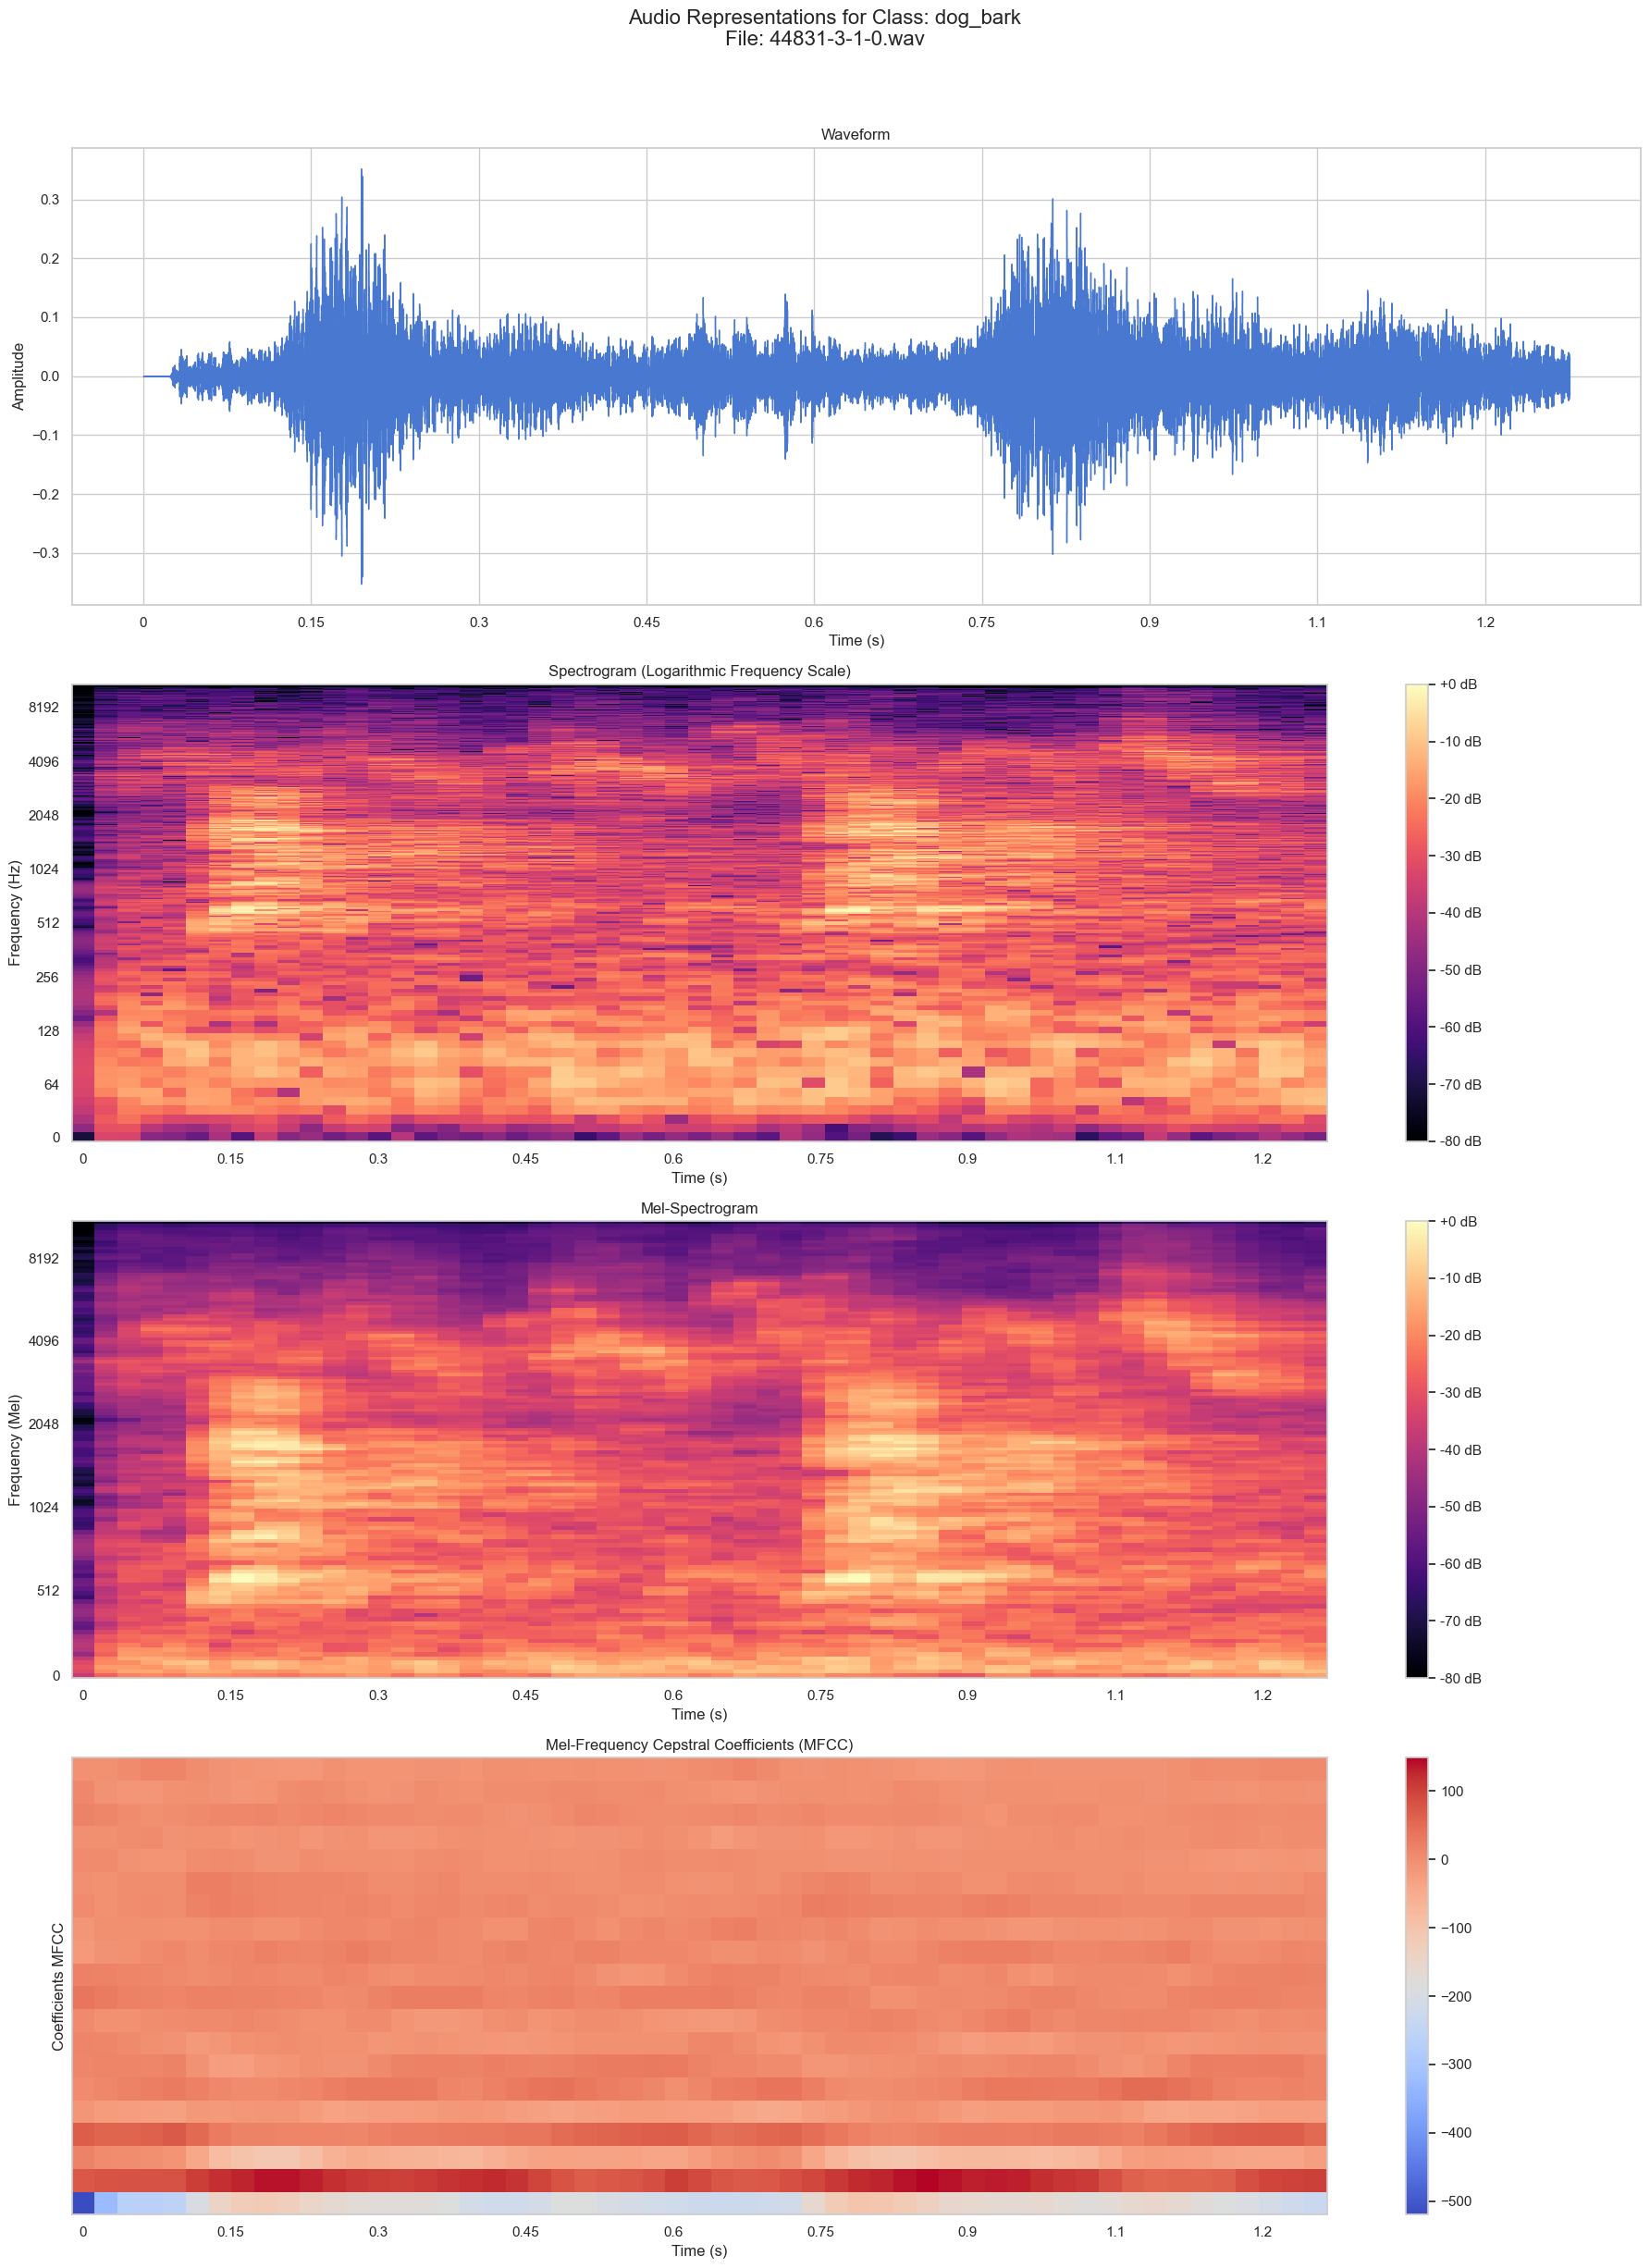

--------------------------------------------------
Displaying a random sample for class: 'siren'
Selected file: 111671-8-0-7.wav


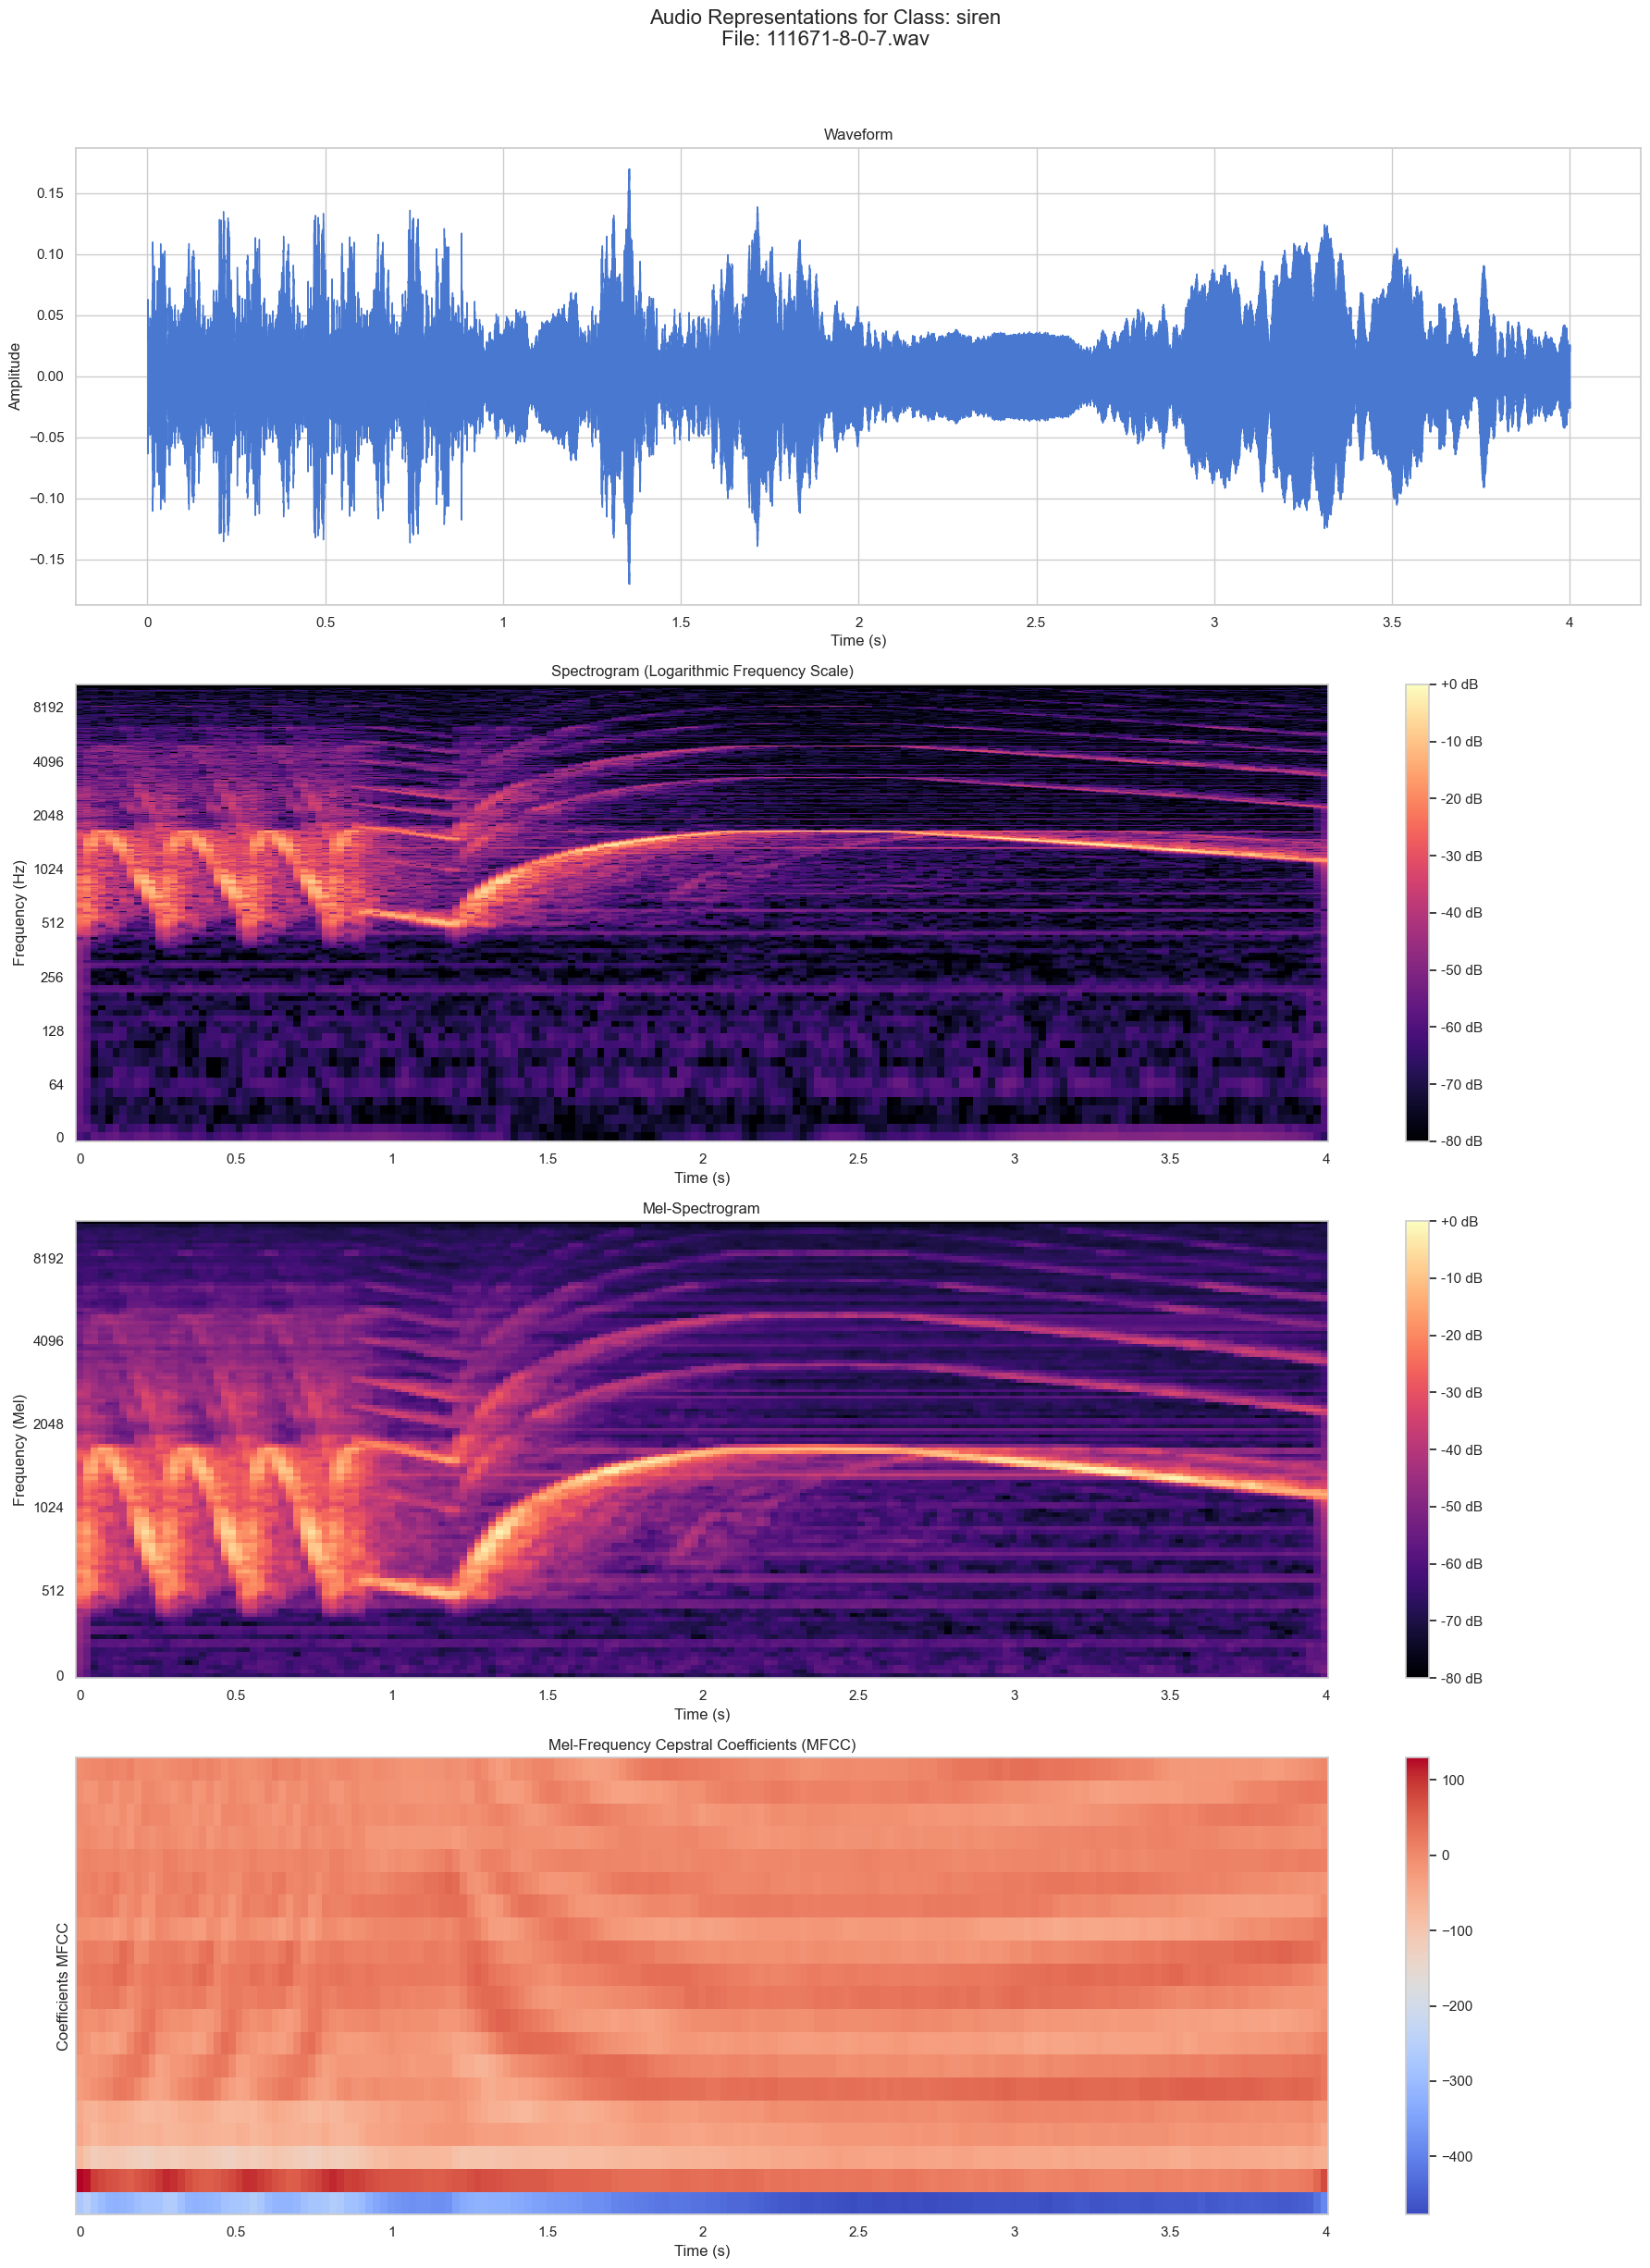

--------------------------------------------------
Displaying a random sample for class: 'air_conditioner'
Selected file: 189023-0-0-2.wav


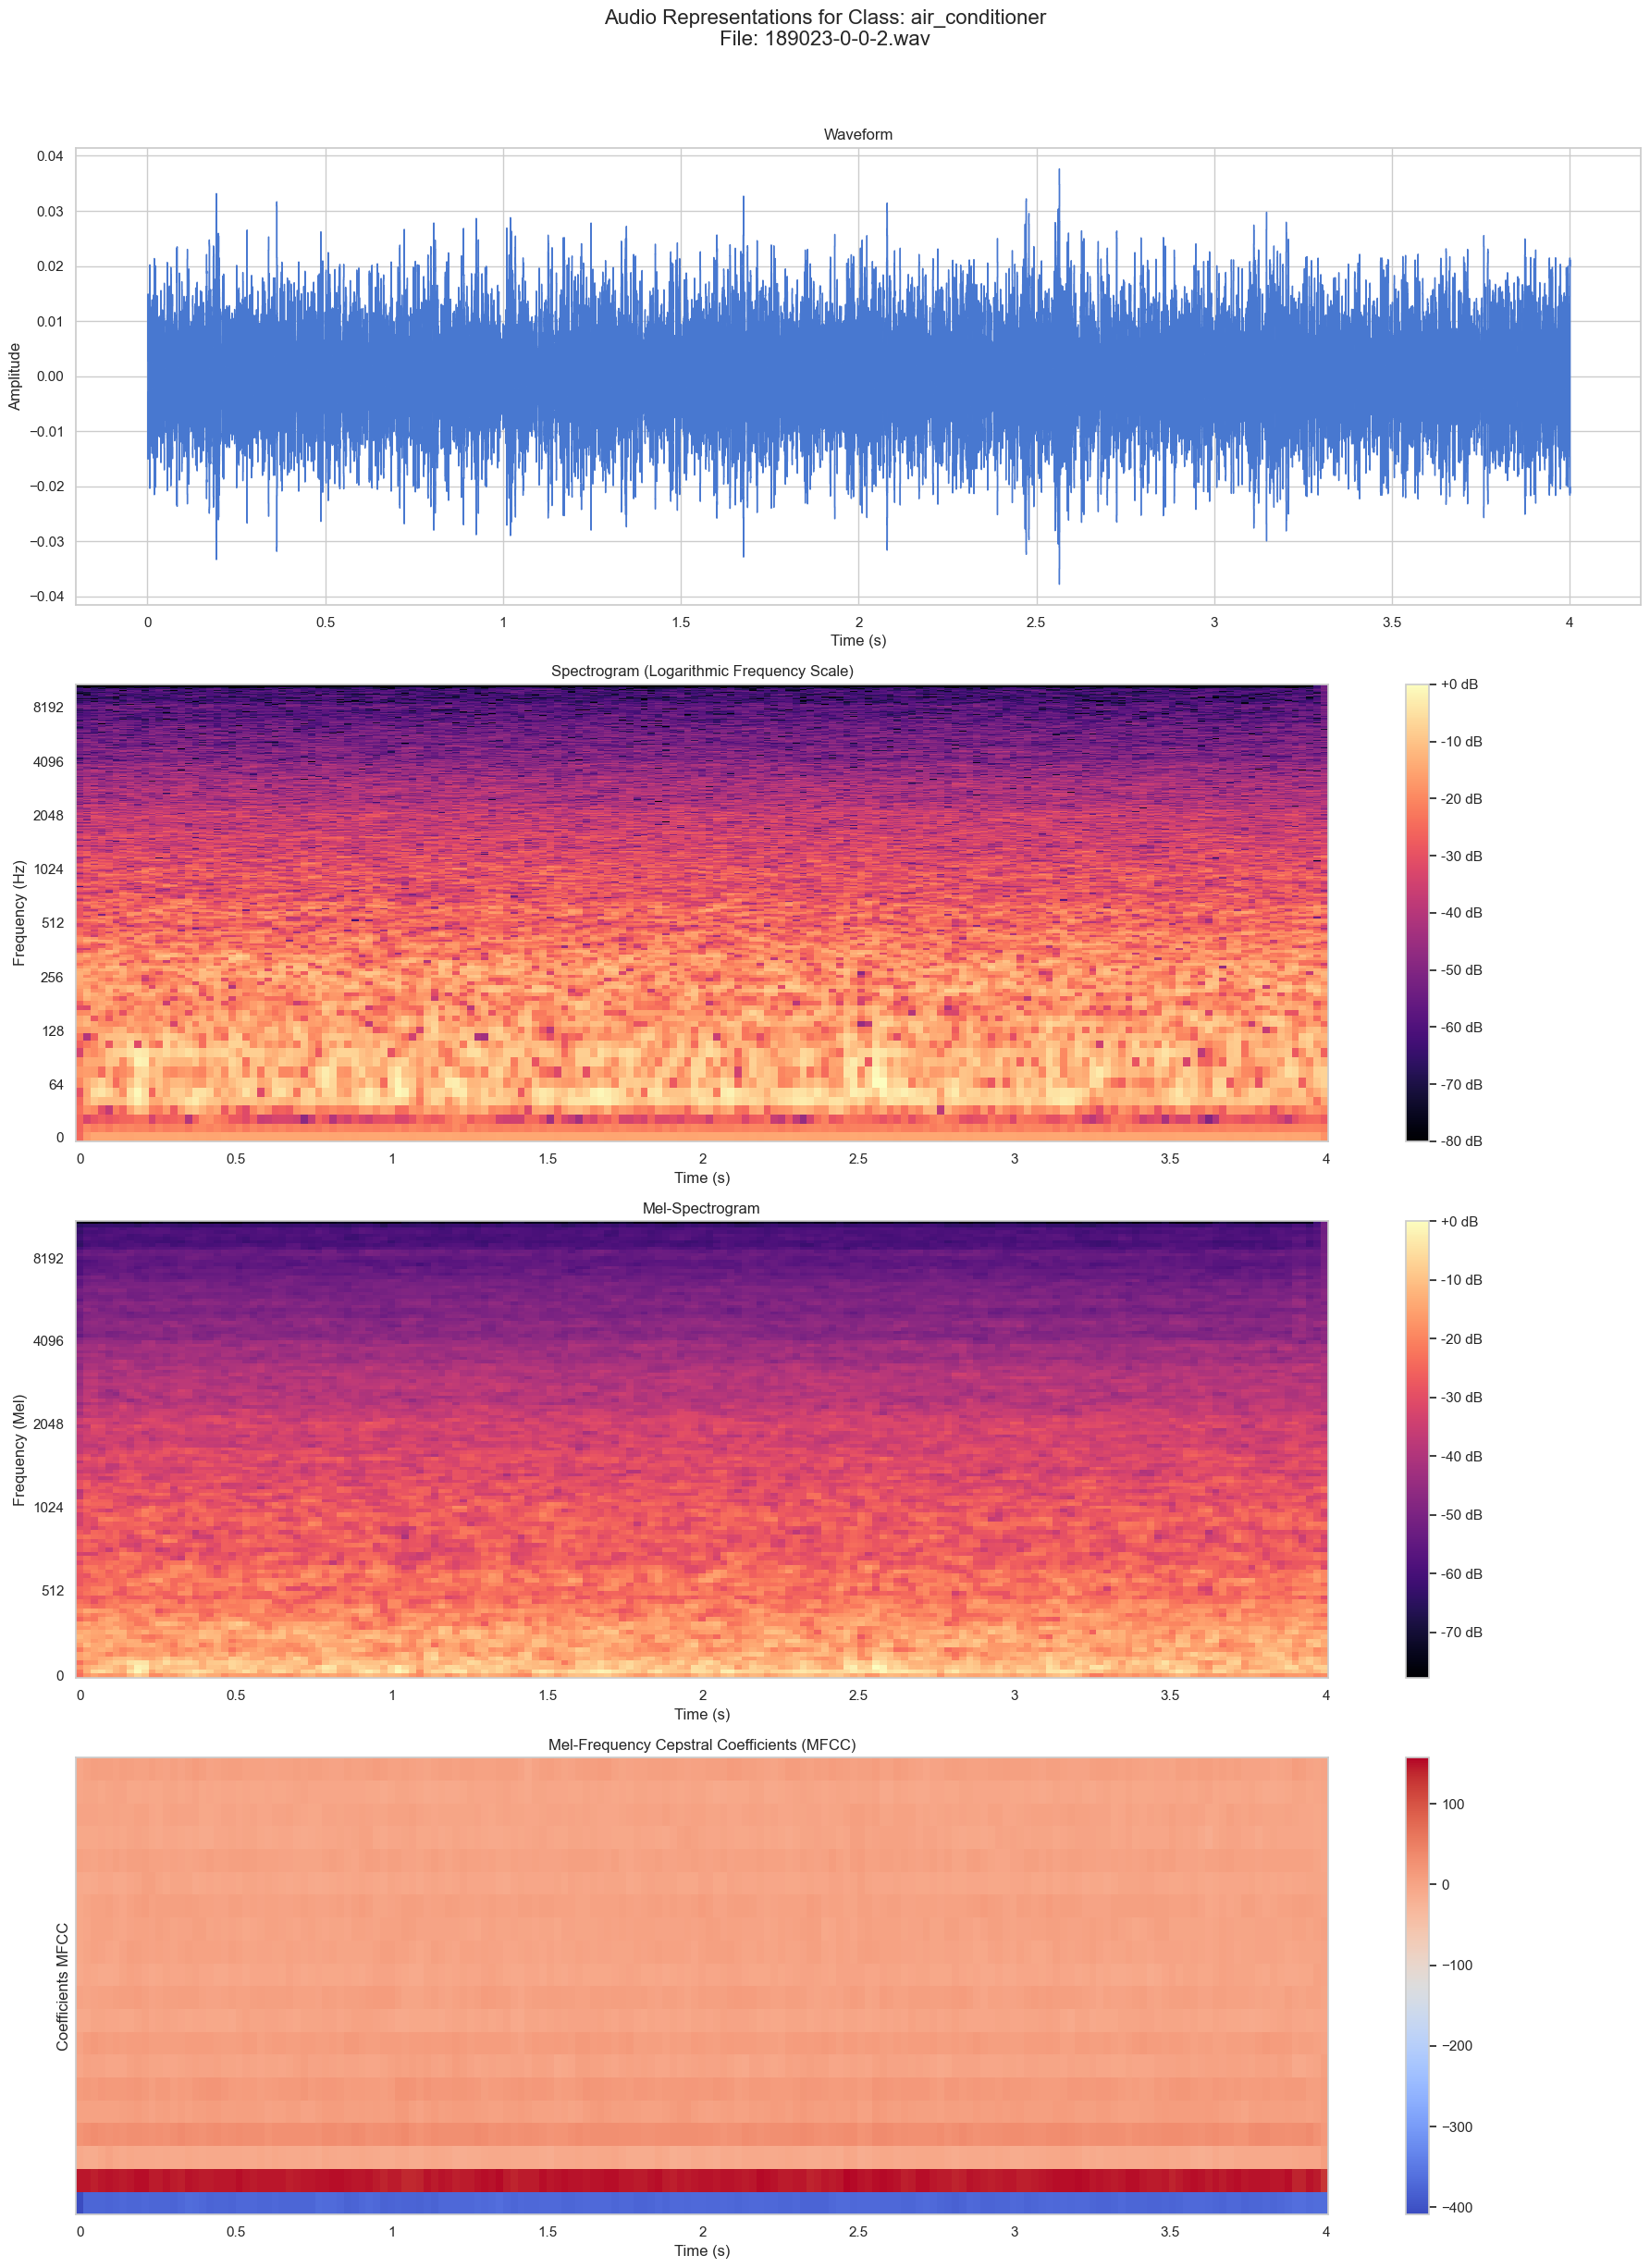

--------------------------------------------------
Displaying a random sample for class: 'car_horn'
Selected file: 26177-1-2-0.wav


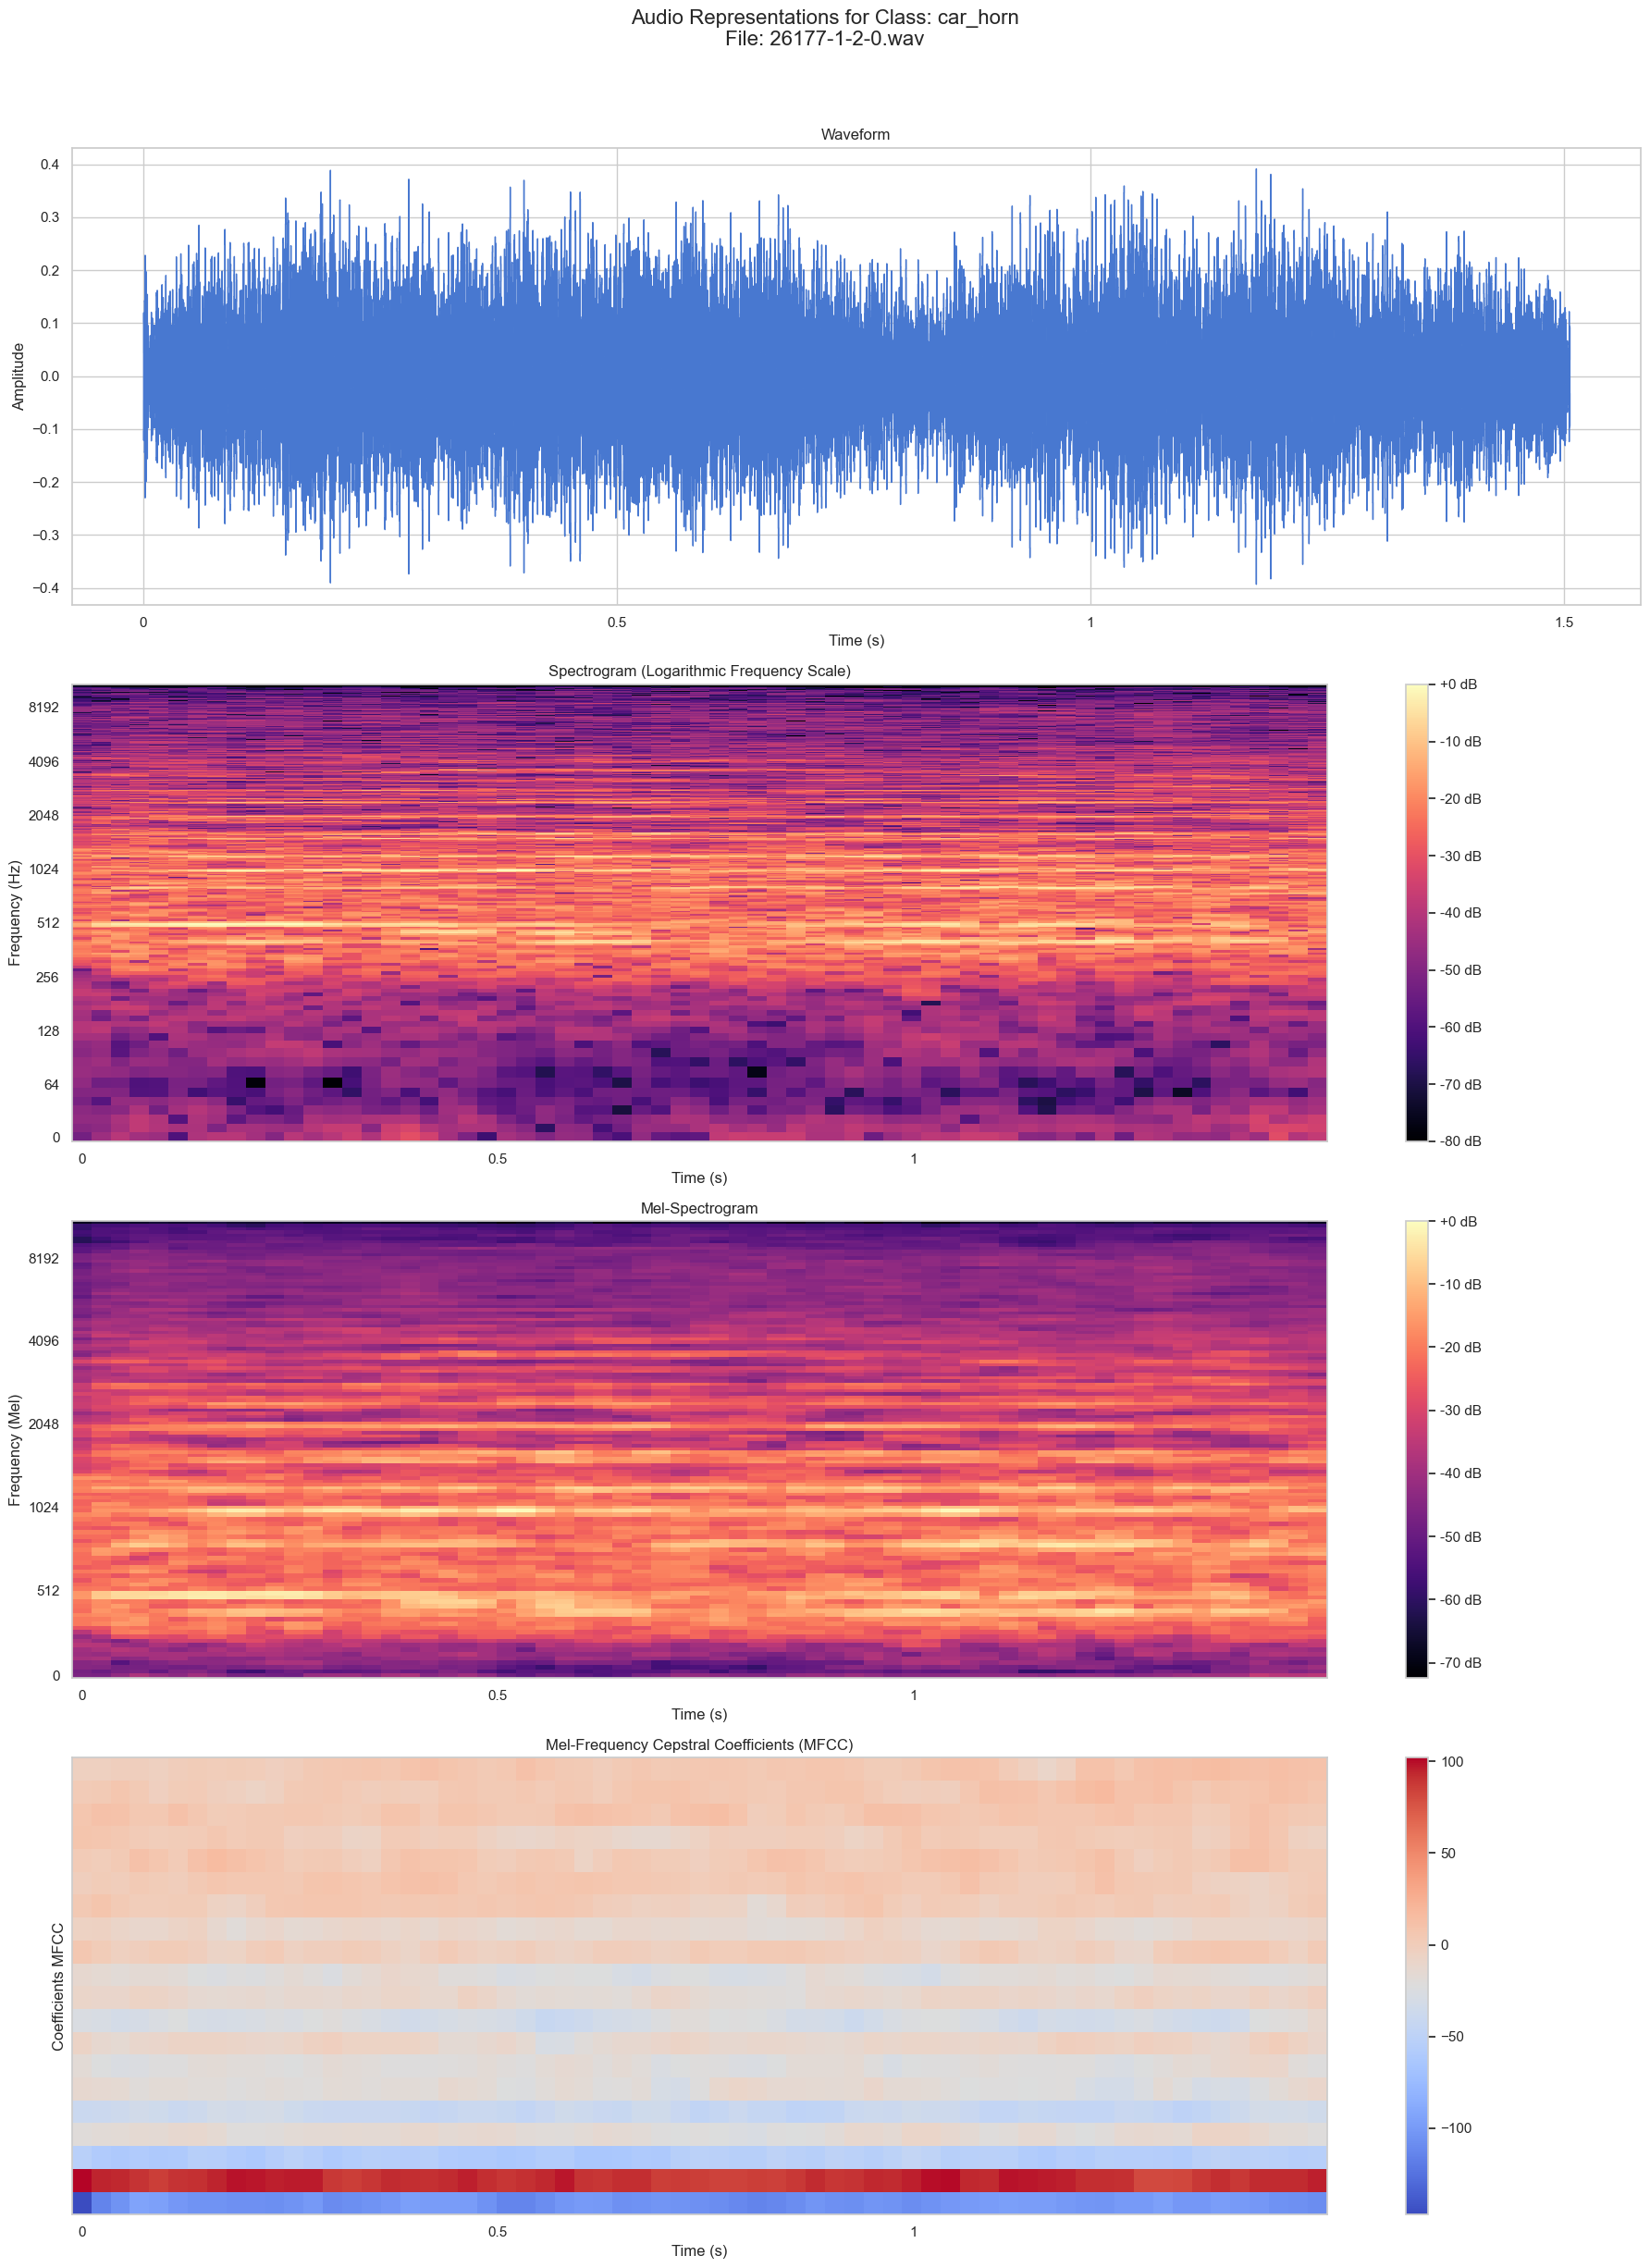

--------------------------------------------------
Displaying a random sample for class: 'children_playing'
Selected file: 196070-2-0-3.wav


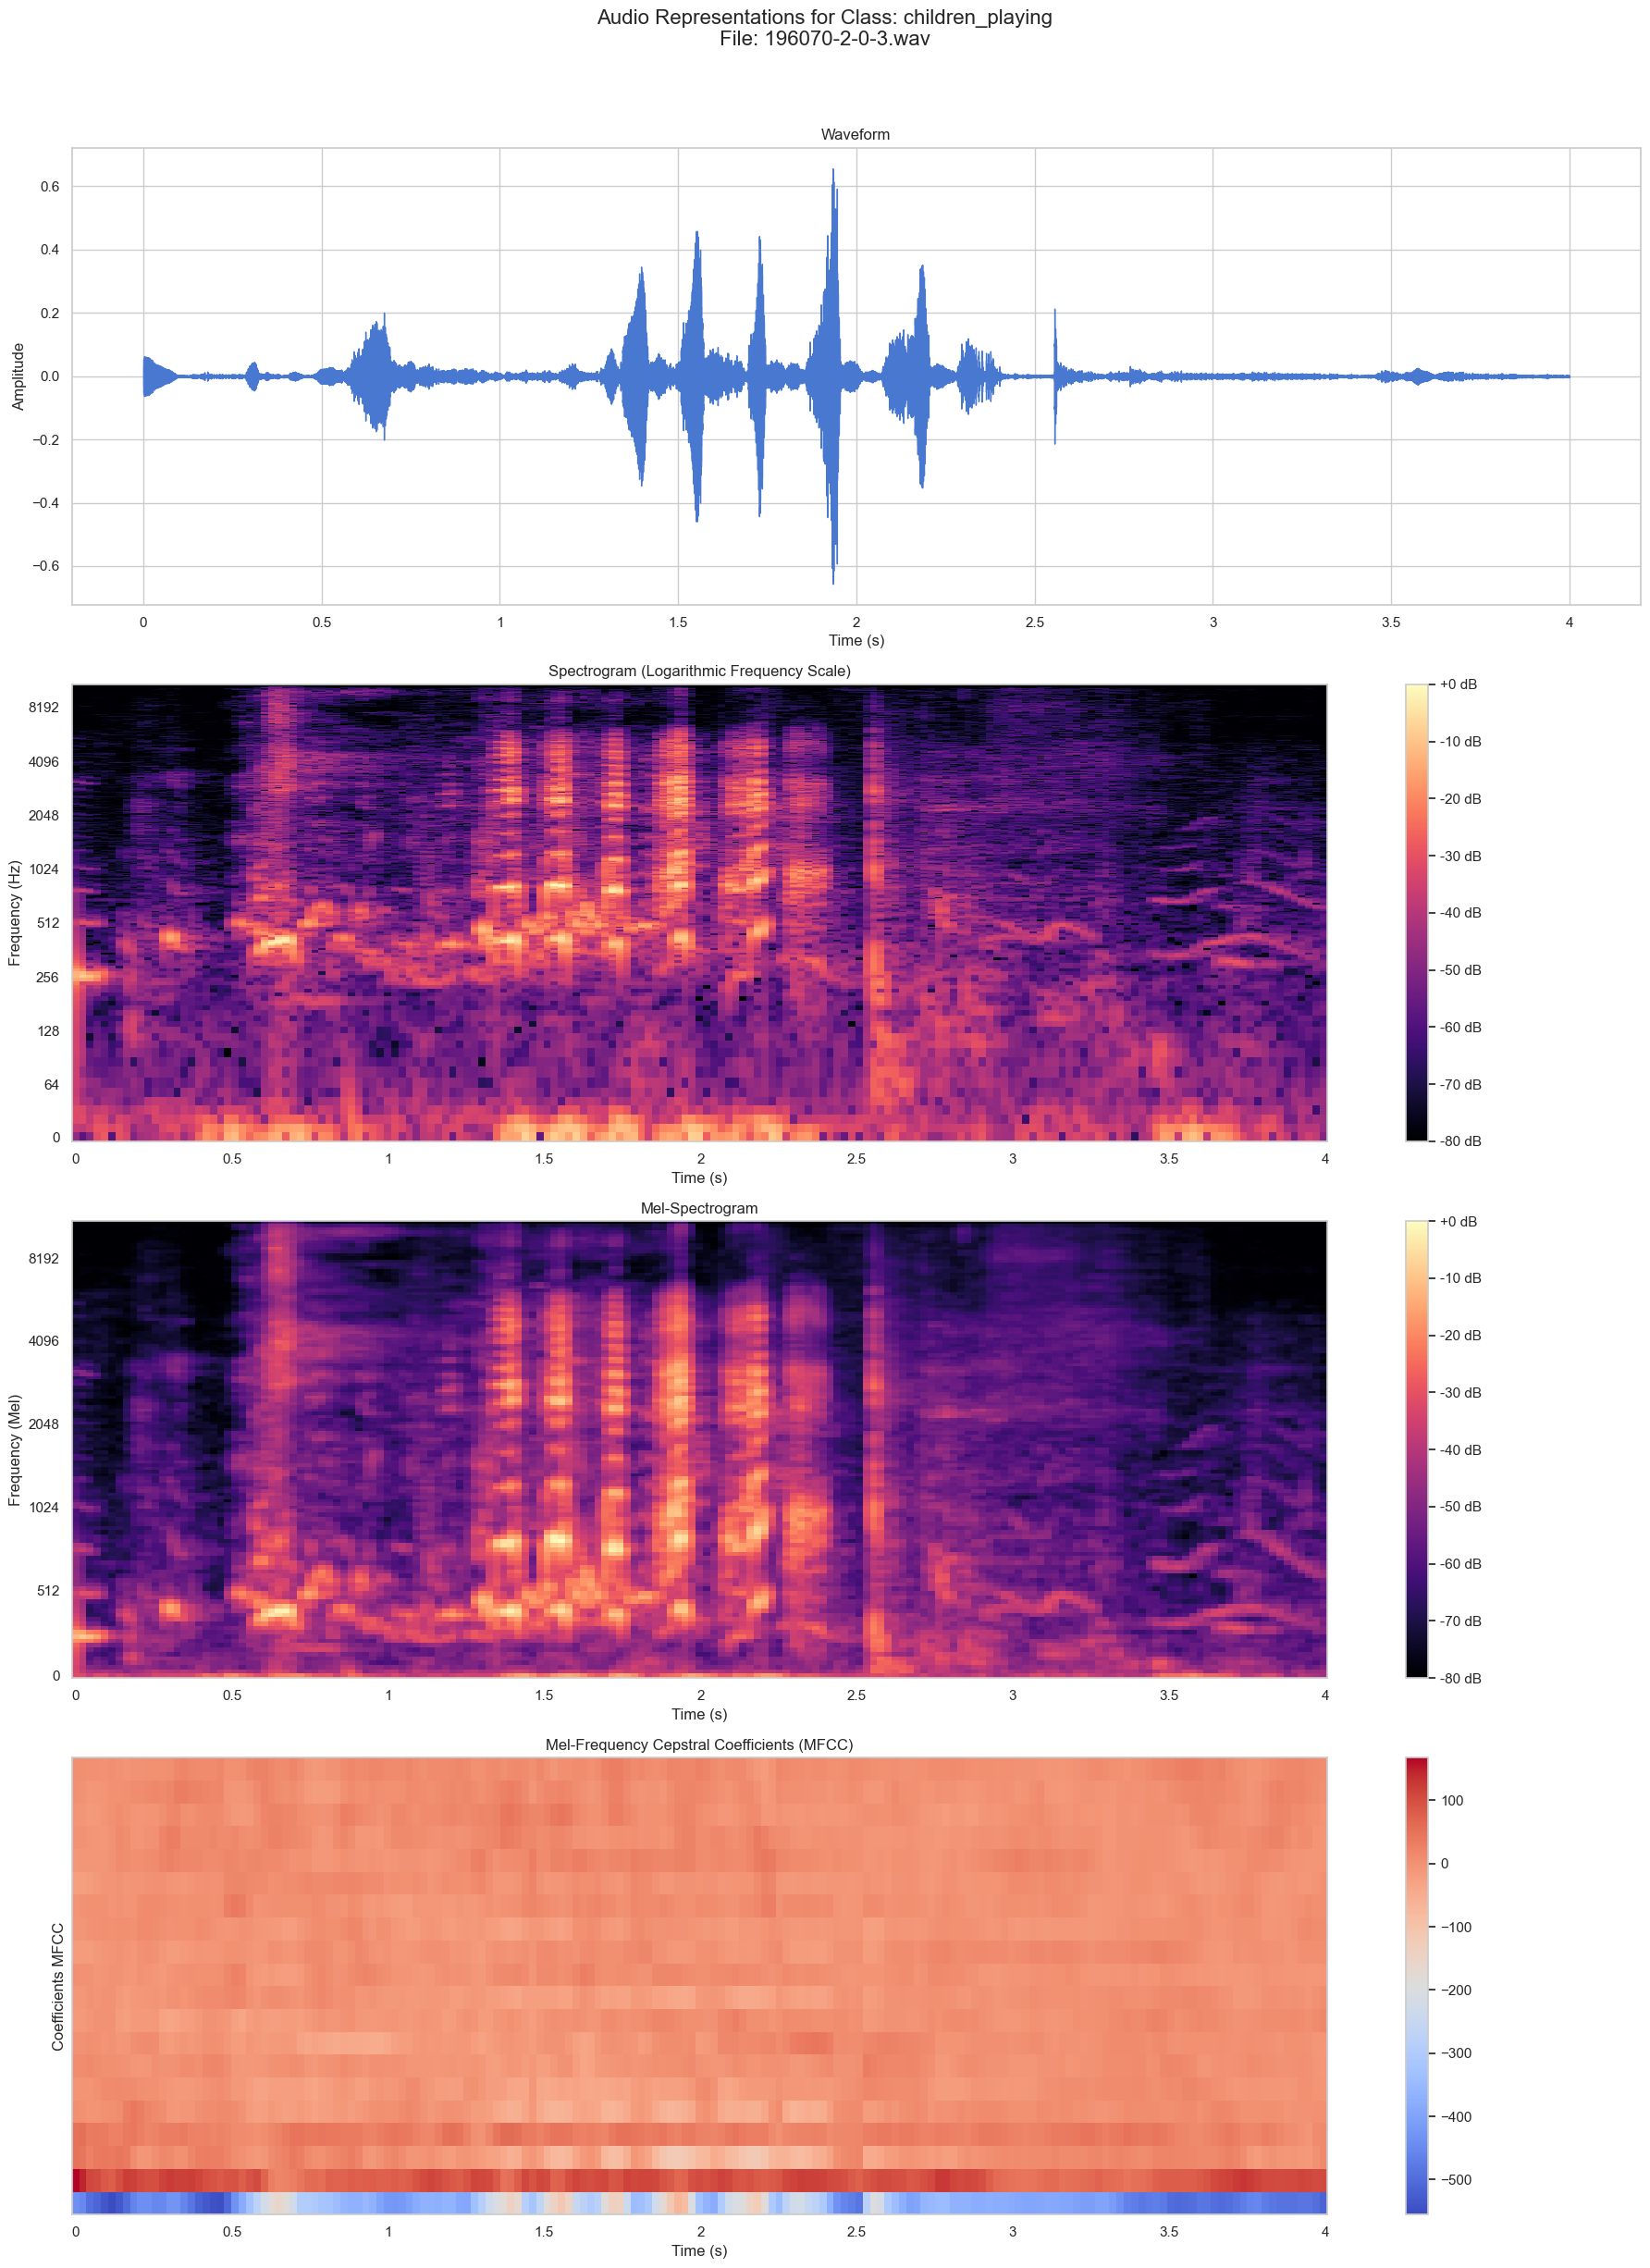

--------------------------------------------------
Displaying a random sample for class: 'street_music'
Selected file: 21684-9-0-7.wav


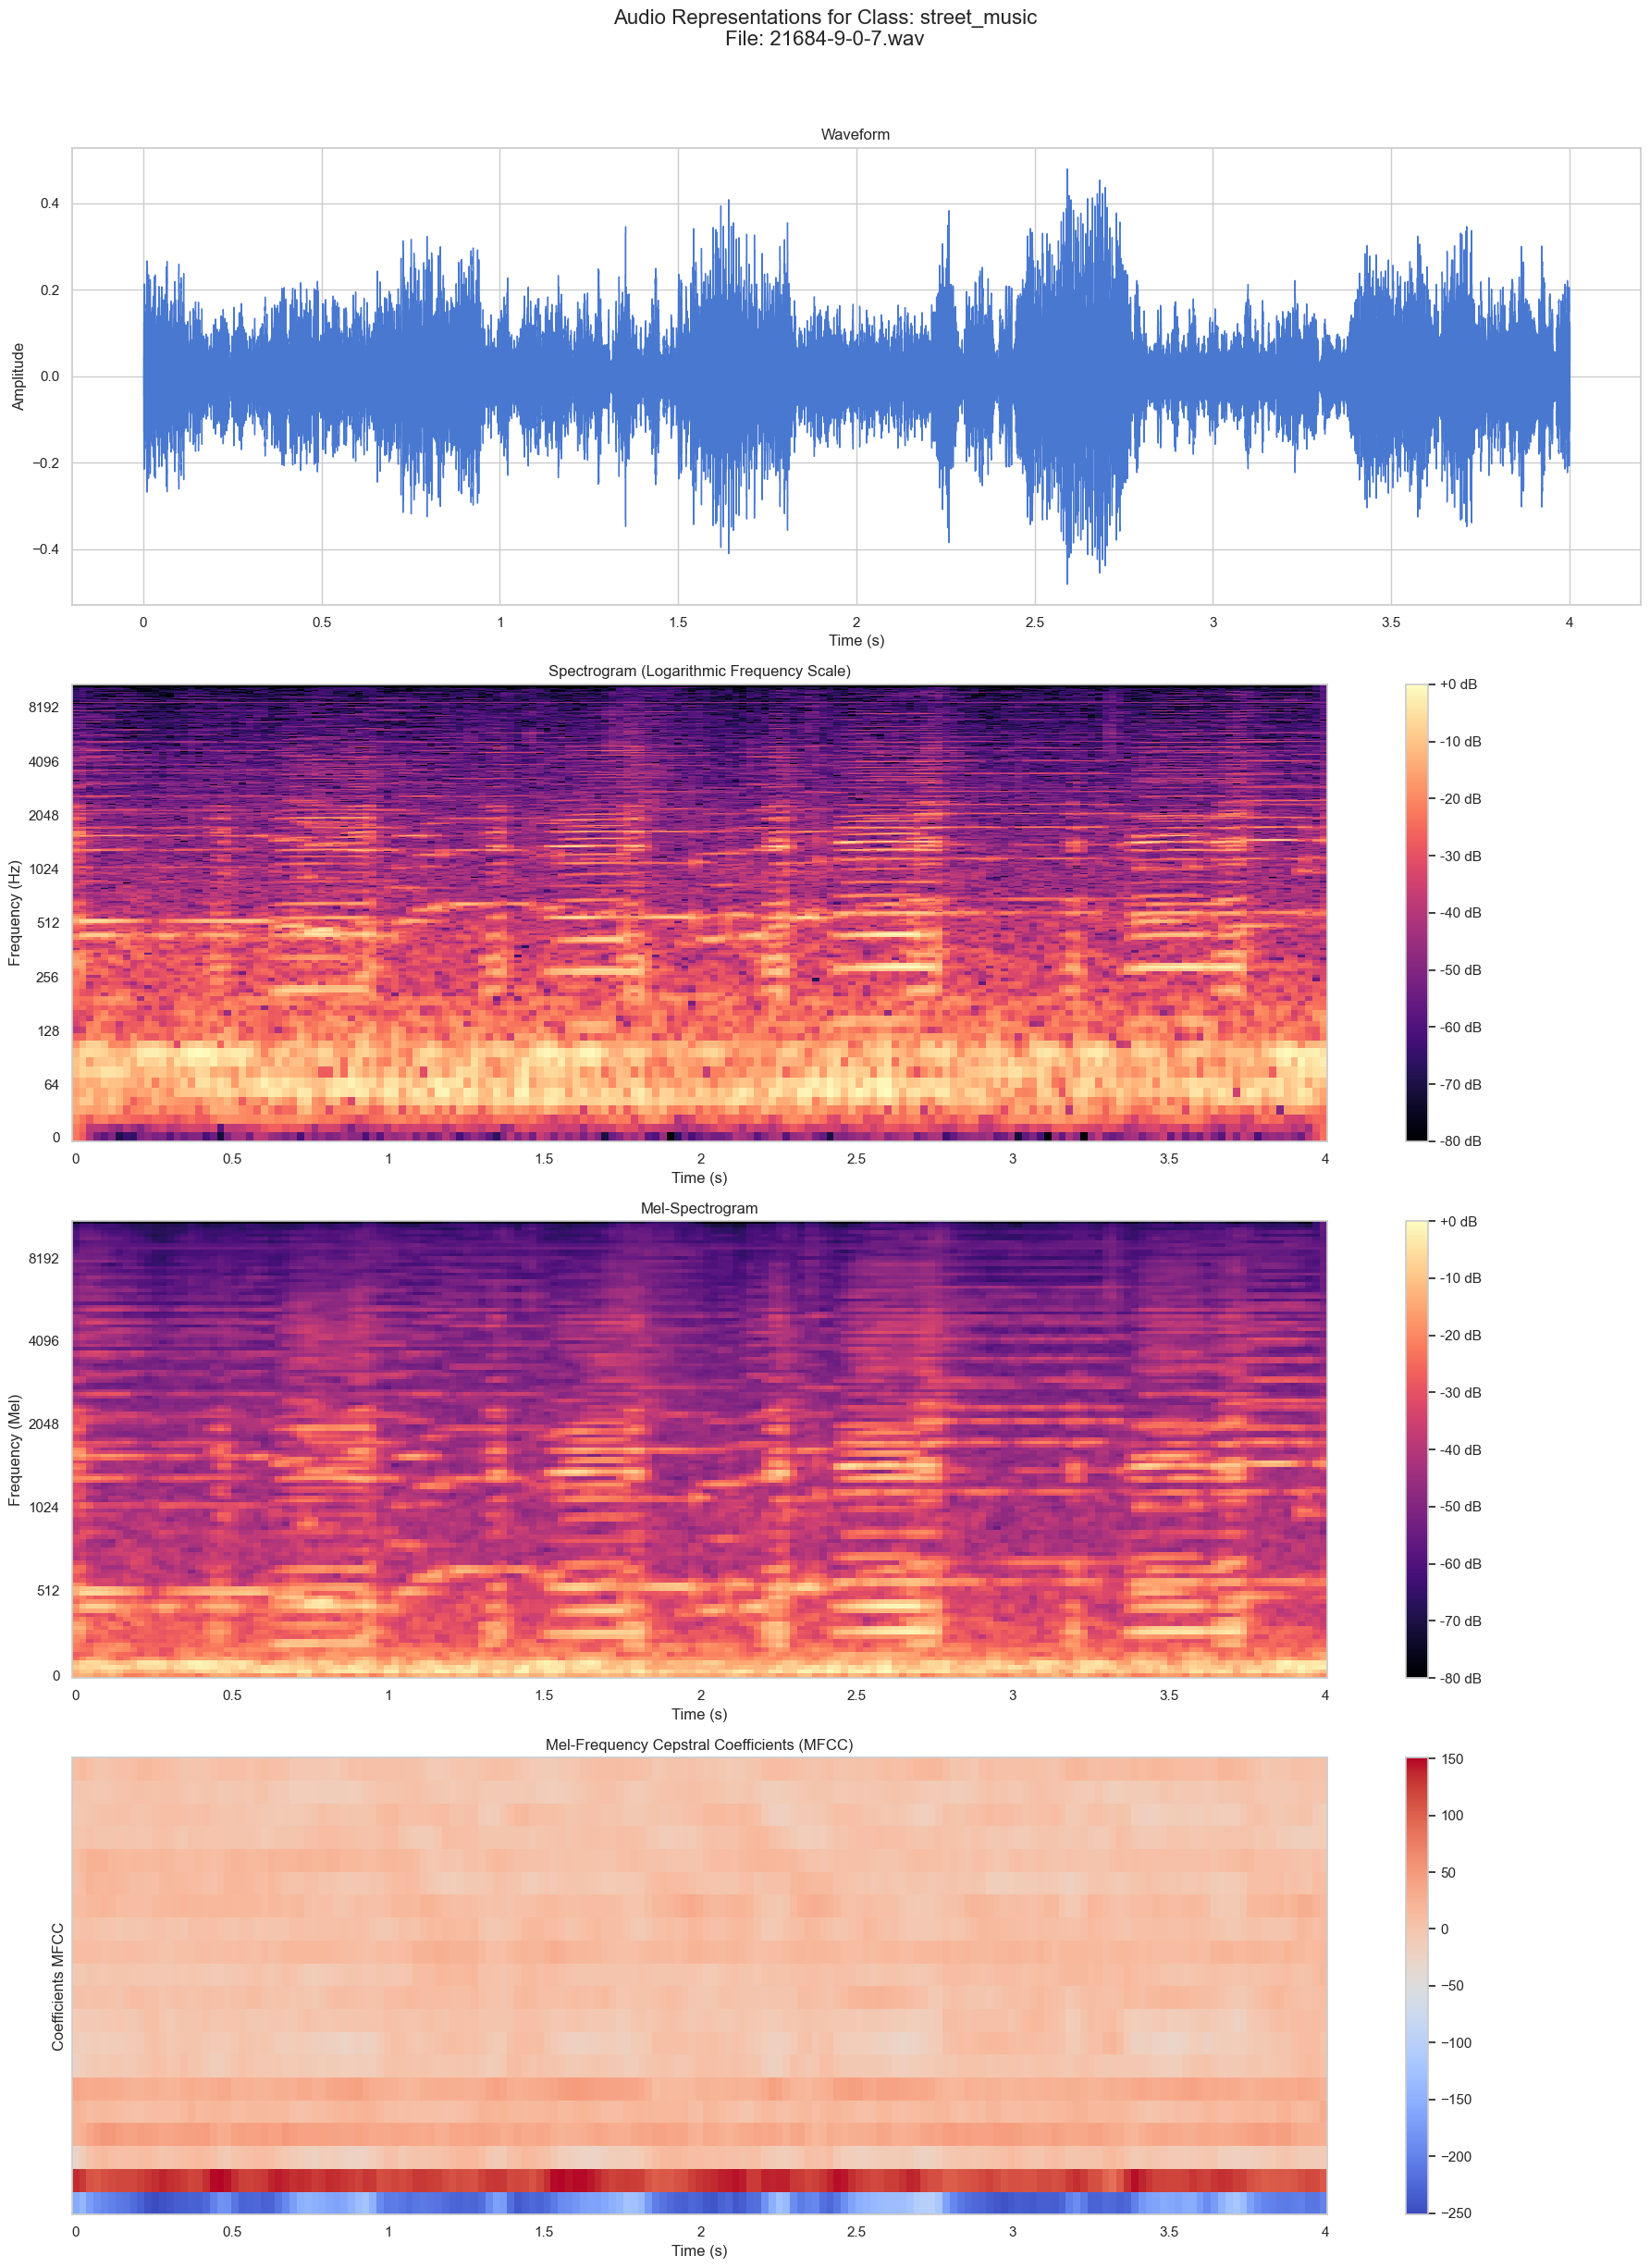

--------------------------------------------------
Displaying a random sample for class: 'gun_shot'
Selected file: 162432-6-9-0.wav


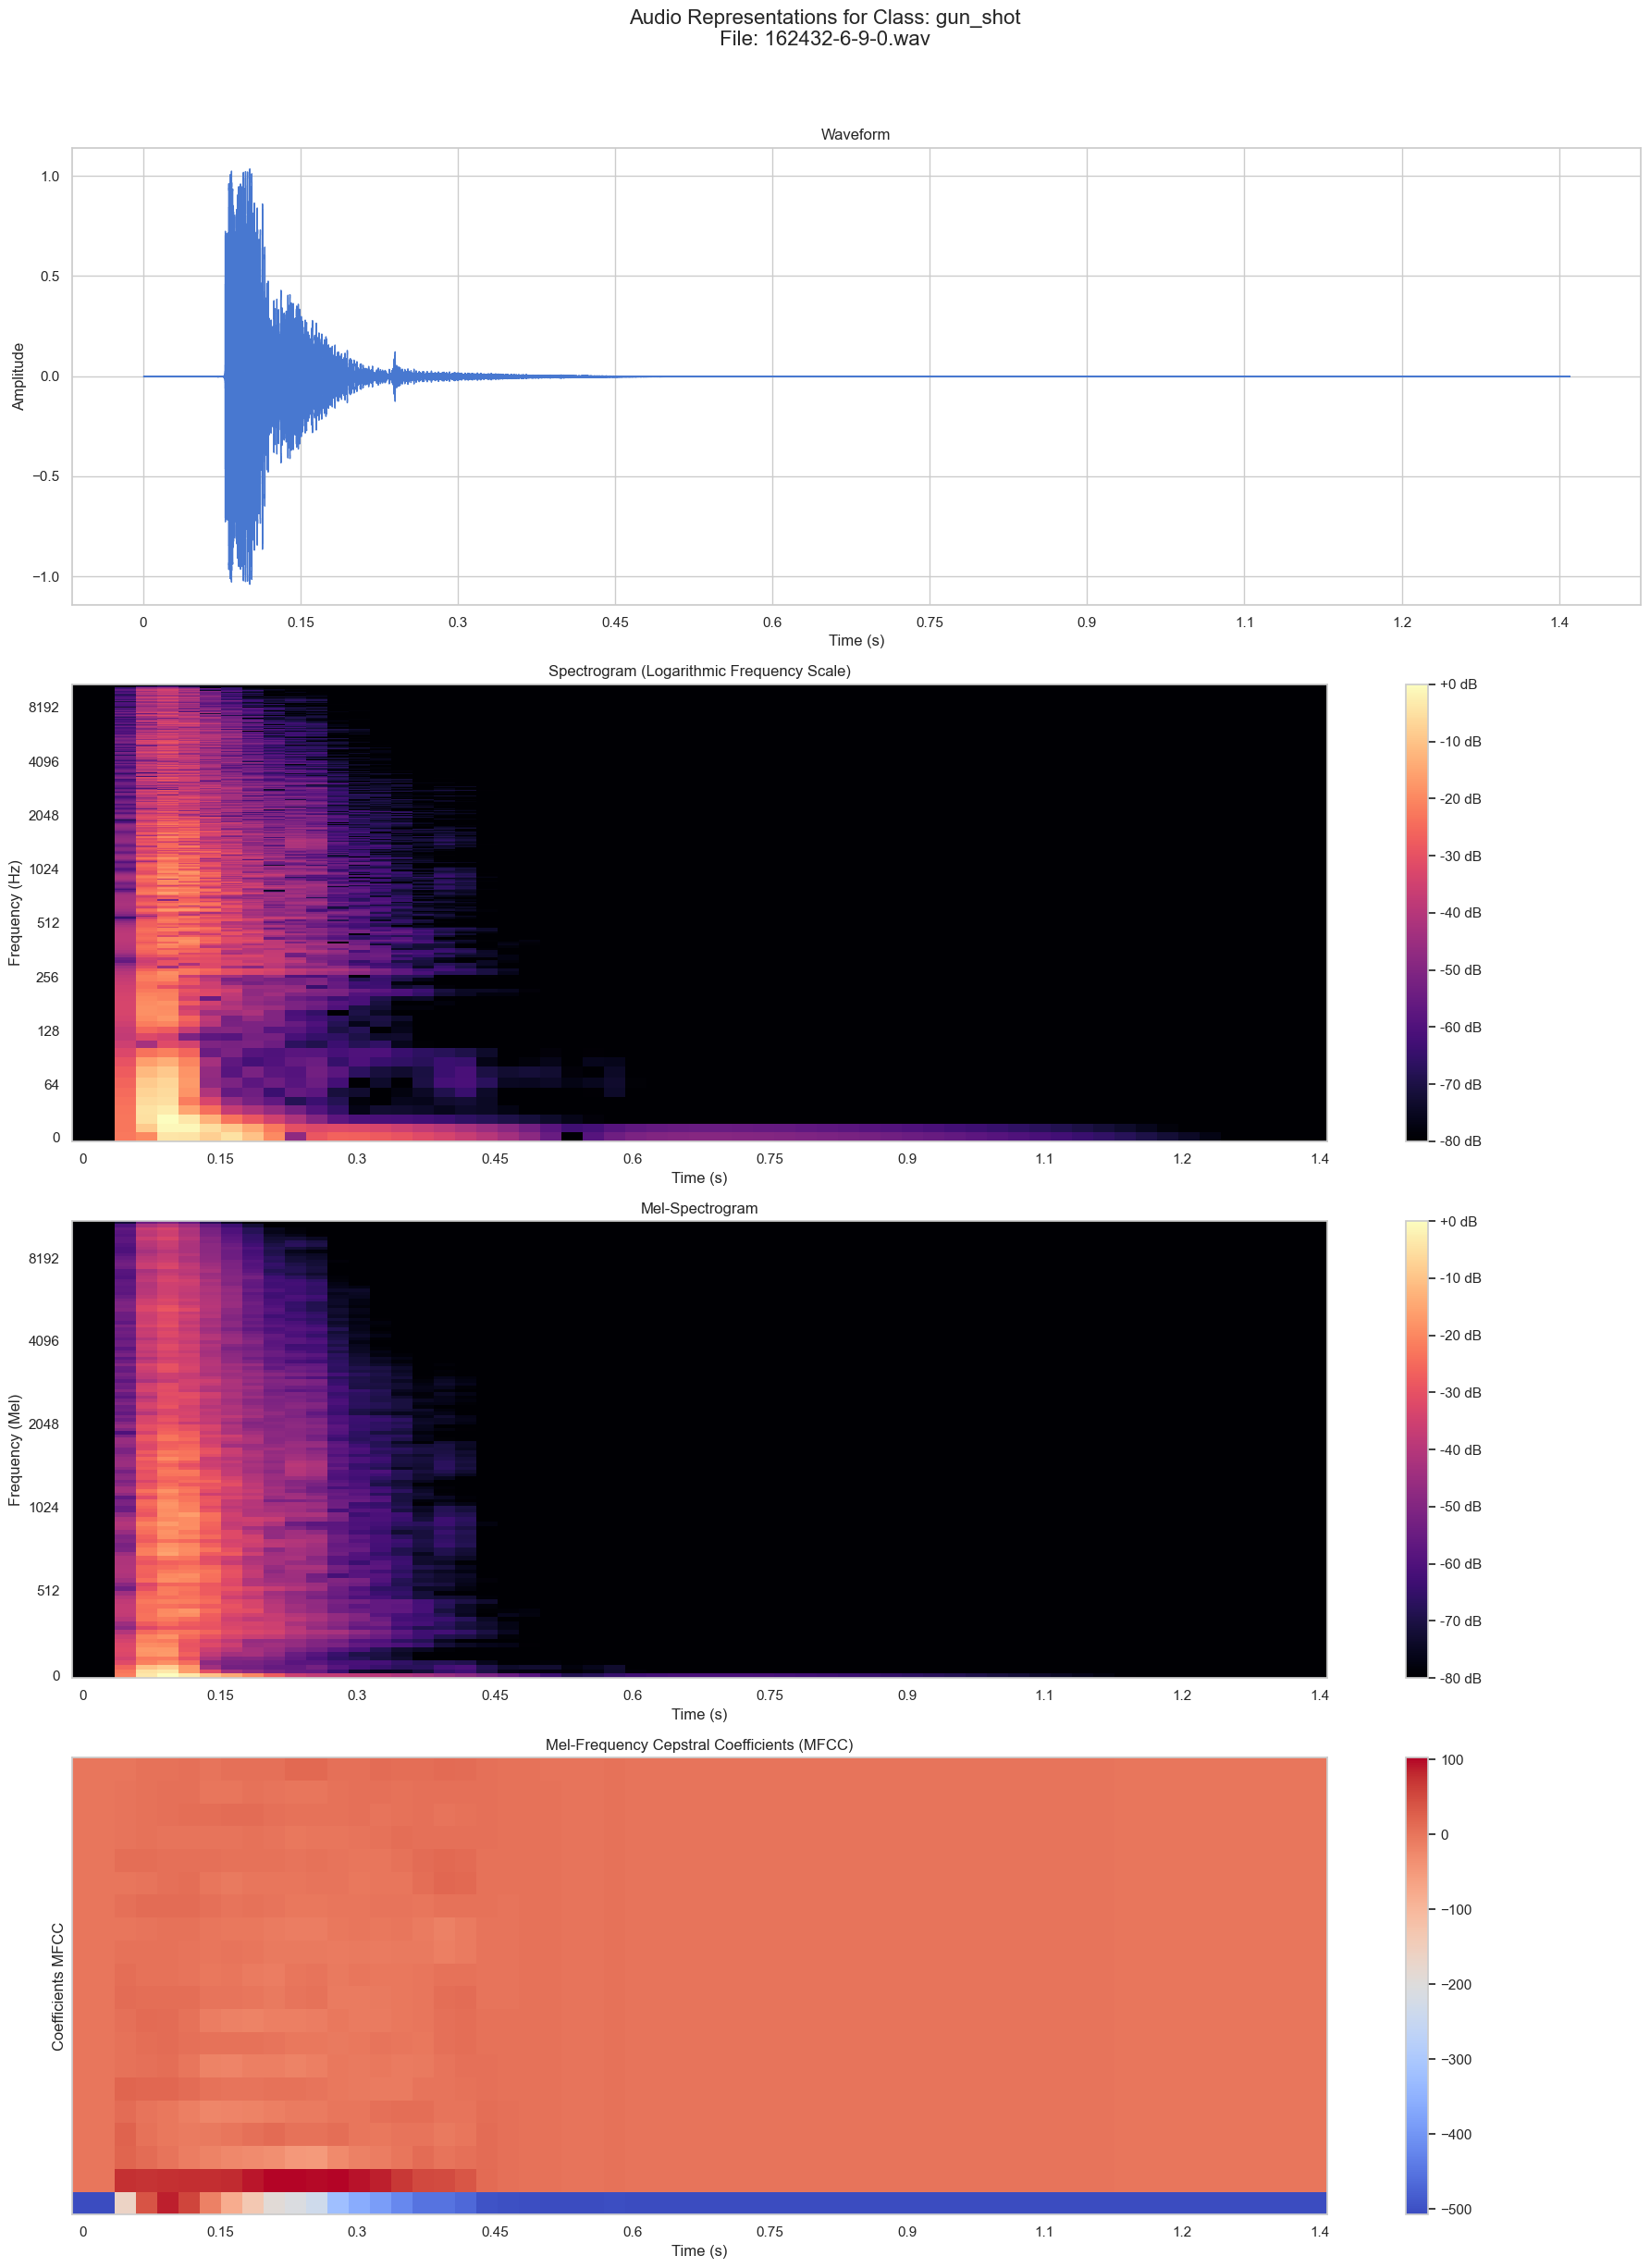

--------------------------------------------------
Displaying a random sample for class: 'drilling'
Selected file: 167701-4-6-2.wav


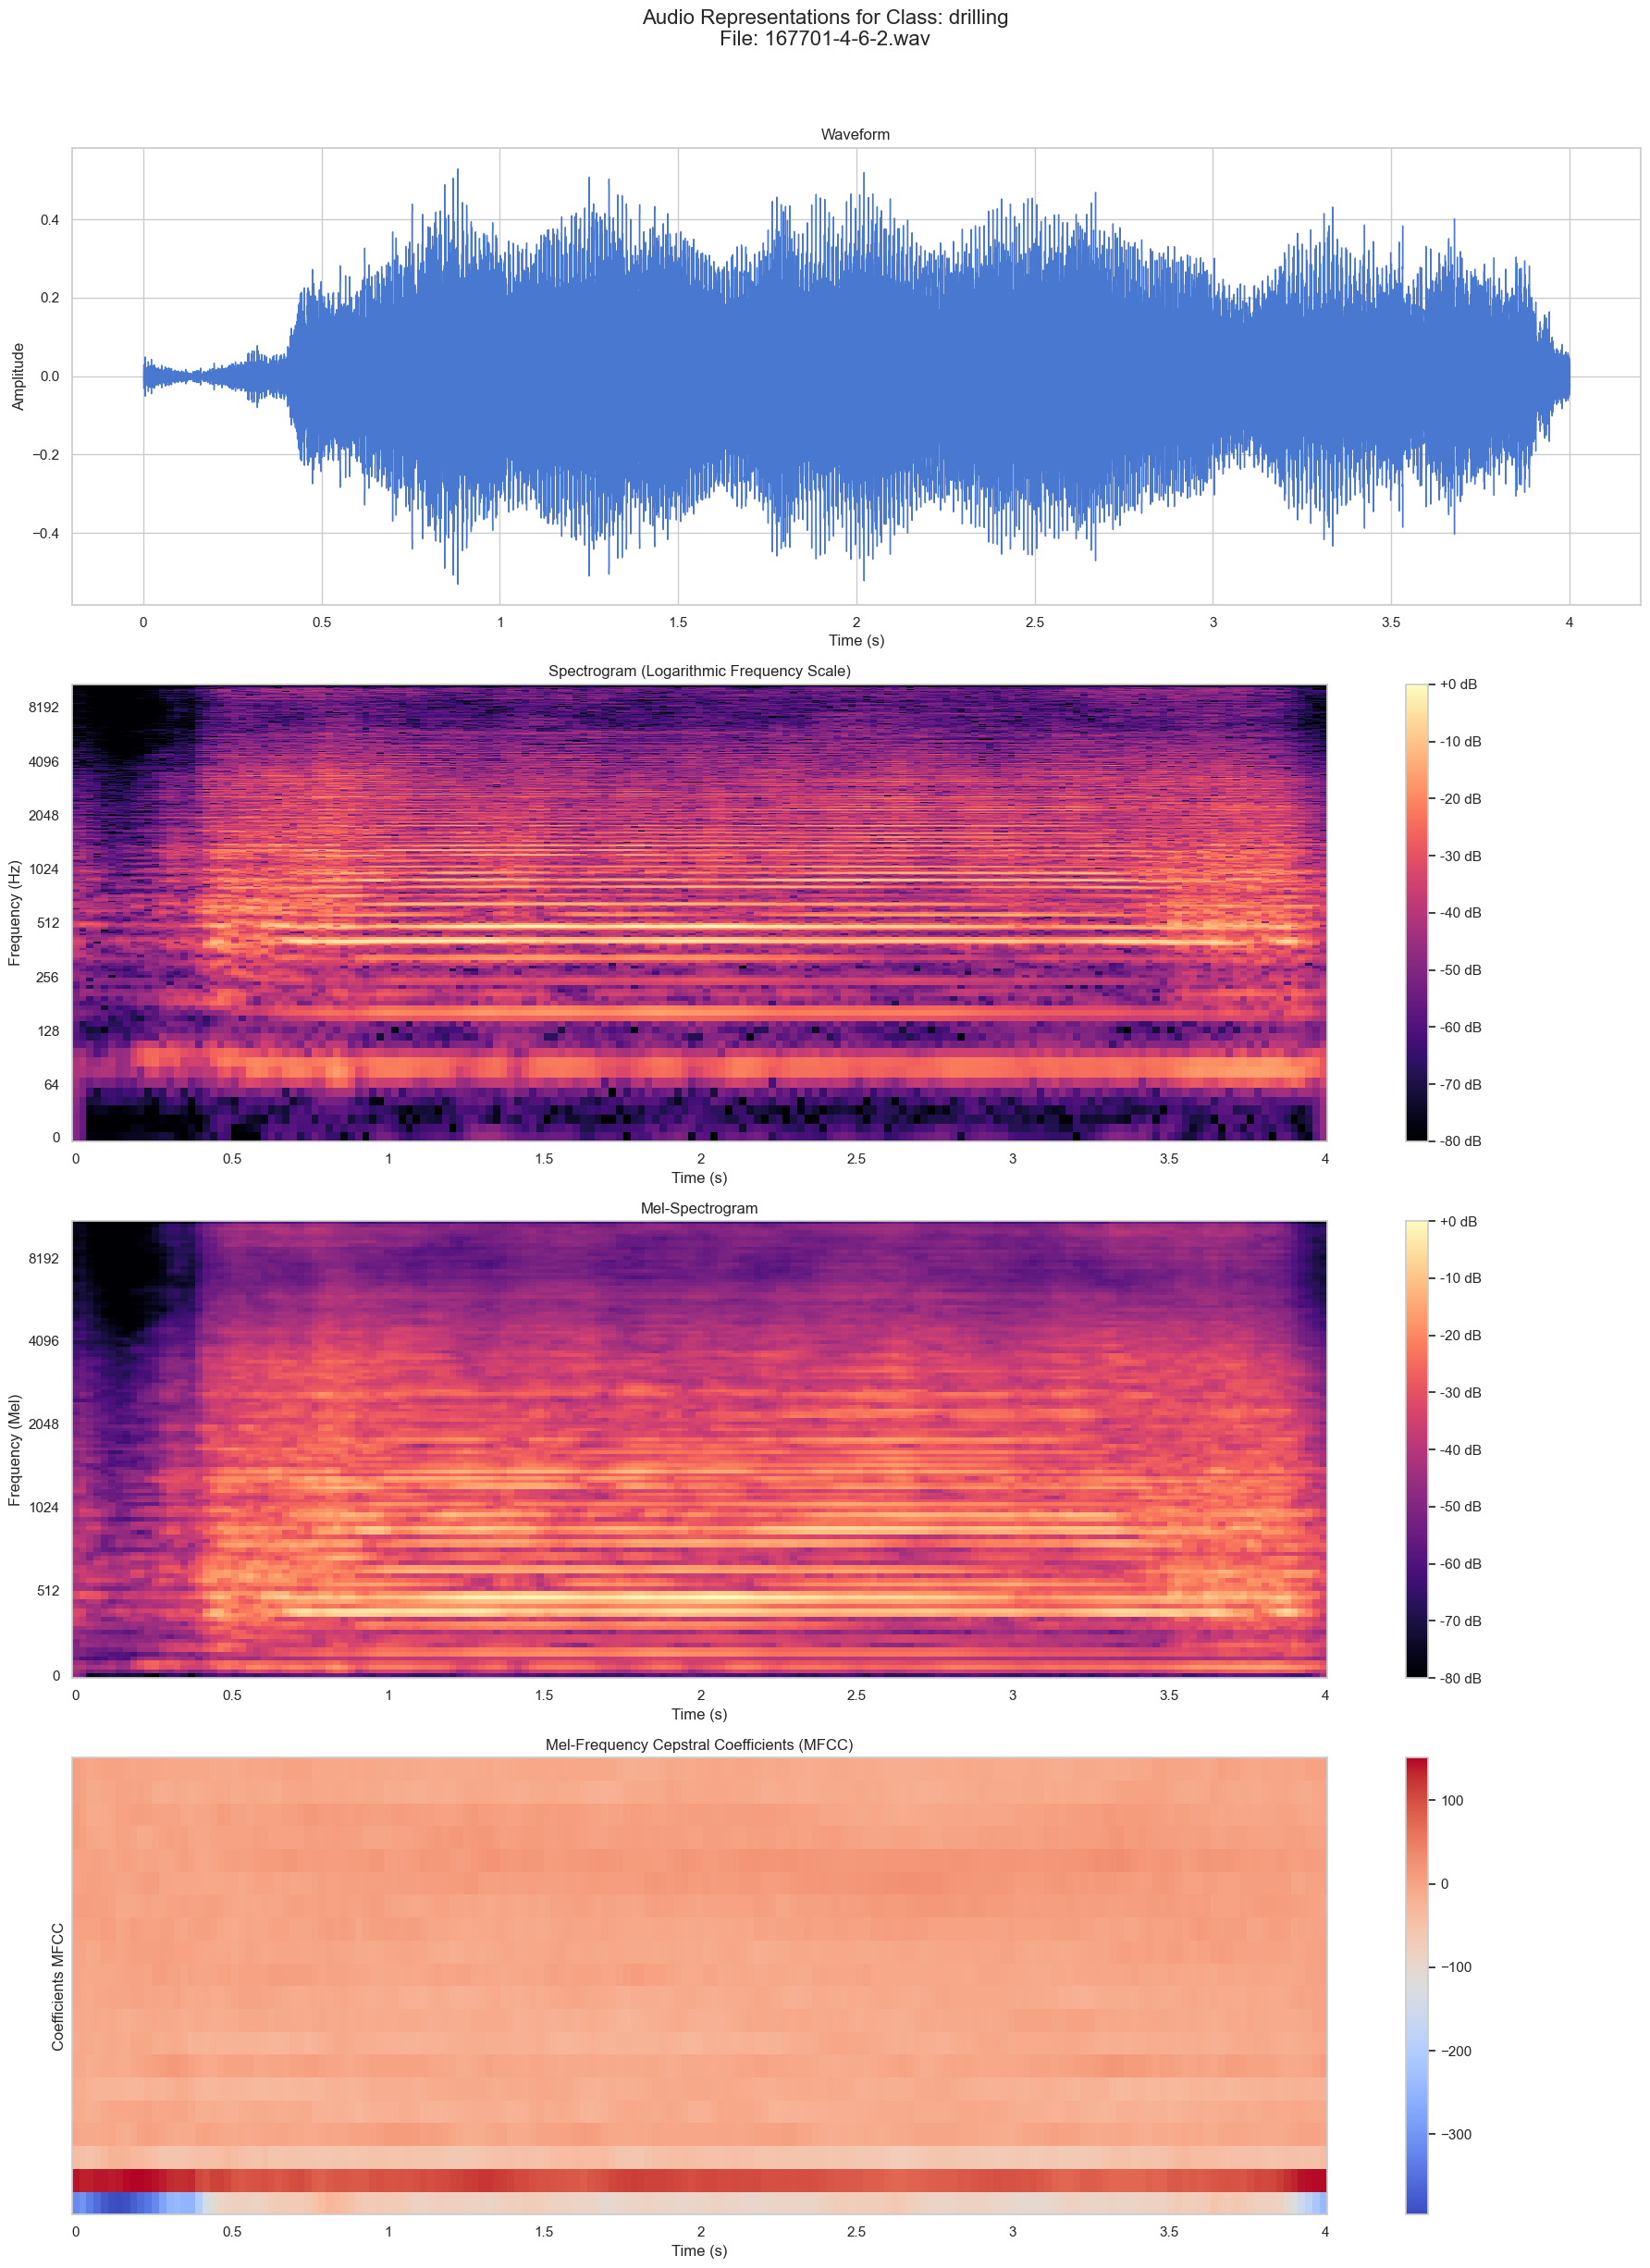

In [16]:
def plot_all_representations(file_path, class_name, sample_rate=22050):
    """
    A function to load an audio file and plot all 4 representations: 
    waveform, spectrogram (log), Mel-spectrogram, and MFCC.
    """
    try:
        y, sr_orig = librosa.load(file_path, sr=None)
        if sr_orig != sample_rate:
            y = librosa.resample(y, orig_sr=sr_orig, target_sr=sample_rate)
        
        plt.figure(figsize=(18, 25))
        # Aggiungiamo un titolo generale alla figura
        plt.suptitle(f'Audio Representations for Class: {class_name}\nFile: {os.path.basename(file_path)}', fontsize=16)

        # 1. Forma d'Onda
        plt.subplot(4, 1, 1)
        librosa.display.waveshow(y, sr=sample_rate)
        plt.title('Waveform')
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        D = librosa.stft(y)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        # 2. Spectrogram (Log)
        plt.subplot(4, 1, 2)
        librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram (Logarithmic Frequency Scale)')
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        

        # 3. Mel-Spectrogram
        S_mel = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_mels=128)
        S_mel_db = librosa.power_to_db(S_mel, ref=np.max)
        plt.subplot(4, 1, 3)
        librosa.display.specshow(S_mel_db, sr=sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-Spectrogram')
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Mel)")
        
        # 4. MFCC
        mfccs = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=20)
        plt.subplot(4, 1, 4)
        librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
        plt.colorbar()
        plt.title('Mel-Frequency Cepstral Coefficients (MFCC)')
        plt.xlabel("Time (s)")
        plt.ylabel("Coefficients MFCC")
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    except Exception as e:
        print(f"Error processing {file_path}: {e}")


def visualize_random_sample_for_class(target_class, sample_rate=22050):
    """
    A "control" function that selects a random file from a given class and 
    calls the plot_all_representations function to visualize it.
    """
    if df is None:
        print("DataFrame 'df' not found.")
        return
        
    class_df = df[df['class'] == target_class]
    if class_df.empty:
        print(f"No files found for class '{target_class}'")
        return
        
    sample = class_df.sample(1).iloc[0]
    file_name = sample['slice_file_name']
    fold_num = sample['fold']
    file_path = os.path.join(AUDIO_BASE_PATH, f"fold{fold_num}", file_name)
    
    print("-" * 50)
    print(f"Displaying a random sample for class: '{target_class}'")
    print(f"Selected file: {file_name}")
    
    plot_all_representations(file_path, target_class, sample_rate)


if 'df' in locals() and df is not None:
    classes_to_plot = [
        'dog_bark',
        'siren',
        'air_conditioner',
        'car_horn',
        'children_playing',
        'street_music',
        'gun_shot',
        'drilling'
    ]
    
    for cls in classes_to_plot:
        visualize_random_sample_for_class(cls)

**Final Observation:**
The different classes have very distinct visual "signatures" in their Mel-spectrograms, for example:
- **`dog_bark`** is a short, impulsive, and broadband event (covering many frequencies).
- **`siren`** shows clear, undulating frequency bands that rise and fall over time.
- **`air_conditioner`** is a stationary, low-frequency noise that is constant over time.
 
These structural differences are precisely what a Convolutional Neural Network (CNN) learns to recognize by treating the spectrogram as an image. This visual analysis gives us confidence that a CNN-based approach is promising for this problem.
